References:
- [[1] Rogers T.J. et al. (2020) On the application of Gaussian process latent force models for joint input-state-parameter estimation : With a view to Bayesian operational identification](https://www.sciencedirect.com/science/article/pii/S0888327019308015)
- [[2] Zou J. et al. (2023) Gaussian Process Latent Force Models for Virtual Sensing in a Monopile-Based Offshore Wind Turbine](https://www.researchgate.net/publication/361411633_Gaussian_Process_Latent_Force_Models_for_Virtual_Sensing_in_a_Monopile-Based_Offshore_Wind_Turbine)
- [[3] Bilbao J. et al. (2022) Virtual sensing in an onshore wind turbine tower using a Gaussian process latent force model](https://www.cambridge.org/core/journals/data-centric-engineering/article/virtual-sensing-in-an-onshore-wind-turbine-tower-using-a-gaussian-process-latent-force-model/33E5A2E422CF50BE5EAA7E5345BA741F)
- [[4] Rogers T.J. et al. (2020) Bayesian Joint Input-State Estimation for Nonlinear Systems](https://www.researchgate.net/publication/344440470_Bayesian_Joint_Input-State_Estimation_for_Nonlinear_Systems)
- [[5] StackOverflow](https://stats.stackexchange.com/questions/387113/convergence-of-the-mat%C3%A9rn-covariance-function-to-the-squared-exponential)

## **Tutorial: GPLFM method for system identification of linear MDOF systems based on acceleration data under unknown forcing**

This notebook will walk you through an application of the so-called **GPLFM method** to the problem of **system identification** of a damped linear multiple degree of freedom (MDOF) system using **time series data** from sensors, as presented in ***[1]***. The time series data is mechanical in nature (i.e. **displacmement, velocity, or acceleration records** of each degree of freedom (DOF) of the system) and is assumed to have been recorded under **unknown forcing of each DOF**. Such data can be called **"operational"** or "in-service" data, as it is recorded while the system is in service. The aim of the notebook is to present the method in a more **practical** way than in the papers. In a way, it could be considered as a supplementary material, complementing the papers. As such, it still is **recommended to read the paper ***[1]*****. 

Other reference papers include ***[2]***,***[3]***. Please note that we take some **notational liberties for (subjectively) better clarity**. The notations we use are **a blend of those used in ***[1]*** and in ***[2]*****.

We consider the case of **acceleration data**, but the method **remains applicable to any combination** of displacement, velocity, or acceleration, while requiring only minimal changes. The case of acceleration data is the most important as acceleration data is by far the most common in the field of **operational modal analysis** (OMA), which is very closely related to our problem. We will briefly discuss the relationship between the problem of operational (or output-only) modal analysis and our method in paragraph 2.3.

The MDOF systems addressed are **linear**. However, recent work has extended the method to address nonlinear MDOF systems ***[4]***.

The data is **synthetically generated** using functions defined in the first part of the notebook (paragraphs 2.2, 2.4). At the end of the notebook, several experiments will be conducted.

The implementation relies on **Tensorflow Probability** (>=0.17).

### **Glossary**

- DOF = Degree of freedom
- MDOF = Multiple degrees of freedom
- GP = Gaussian process
- LFM = Latent force model
- GPLFM = GP+LFM
- LTI SDE = Linear time-independent Stochastic Differential Equation
- MCMC = Markov chain Monte Carlo
- RWM = Random walk metropolis
- SSM = State space model
- LGSSM = Linear gaussian state space model

## **1. Introduction**

#### **1.1. MDOF system identification: what problem are we trying to solve ? And why ?**

The problem we're trying to solve is that of **finding the system parameters** (masses, stiffnesses, damping coefficients) of a linear MDOF system. The only data are acceleration time series for each mass (i.e. DOF), recorded under unknown forcing of each one of them.

Although they are simple models, damped linear MDOF system models and second-order differential equations of movement are **widespread** in science (structural dynamics, computational physics...) and engineering (civil, mechanical...). As such, there can be a need to **validate** the correctness and appropriateness of such models for real structures (for example, a bridge or a car part). This means checking whether the model and the real data recorded on the structure are consistent. One way to do that is to check whether the parameters used in the initial model, and those inferred from real data are the same (or at least very close). However, it can be **very difficult to interpret real data** when the external influences the structure is subject to during data acquisition **cannot be known or controlled**. This is often the case, and serves as the premise for operational modal analysis. This illustrates the relevance of our system identification problem.

#### **1.2. Overview of the method**

The so-called GPLFM method is grounded in the **Bayesian inference framework**. The idea is to use Bayesian inference to estimate a probability distribution of the system parameters (masses, stiffnesses, damping coefficients), as well as the unknown forcing. Additionally, the method is able to deal with noise in the data. The following steps present a **summary** of the idea and theory behind the method:

1. The unknown forcing $f$ is assumed to be modeled as a **Gaussian process**. The mean of the Gaussian process is assumed to be $0$, and its covariance function is assumed to be a **Matérn covariance function** $\kappa$, with (hyper)parameters $\nu$, $\sigma_{f}$ and $l_{f}$. As such, we have that $$\forall i\in[1...N] \ f_{i}(t) \sim GP(0,\kappa_{i}(t,\cdot))$$ where $N$ is the number of DOFs.

***Note***: In ***[1]***, it is assumed that the same force acts on all DOFs. In ***[2]***, this assumption is lifted, but it is assumed that the same hyperparameters (and thus the same covariance function) are used for all the forces. In this notebook, we lift this assumption as well and allow each force to have its own covariance function hyperparameters. As such, for each DOF $i$, $\kappa_{i}$ is parametrised by $\nu_{i}$, $\sigma_{fi}$ and $l_{fi}$.

2. Considering the assumption above, the linear MDOF system's equation of movement is written in (continuous-time) state space form with the force $f$ as the external input. It is a so-called **latent force model** ***[X]***: $$M\ddot{r}(t)+C\dot{r}(t)+Kr(t)=f(t) \newline \forall i\in[1...N] \ f_{i}(t) \sim GP(0,\kappa_{i}(t,\cdot))$$ where
    - $t$ refers to time
    - $N$ is the number of DOFs
    - $r(t)$ is the displacement vector (i.e. $r_{i}(t)$ is the displacement of the $i$-th DOF, relatively to its initial (resting) position)
    - $M$ is the mass matrix
    - $C$ is the matrix of damping coefficients
    - $K$ is the matrix of stiffnesses

***Note***: The relation between individual parameters of the system $\{m_{i} \ | \ i\in[1...N]\}$, $\{k_{i} \ | \ i\in[1...N+1]\}$, $\{c_{i} \ | \ i\in[1...N+1]\}$ and matrices $M$, $K$, $C$ is easily obtained by looking at the (elastic and viscous damping) forces acting on each mass. See paragraph 2.2.

***Note***: The intuition behind the term "latent force model" is that the force $f$ is seen as a latent variable (as in "latent variable model"). Latent variables are variables that can only be inferred indirectly through a mathematical model from other observable variables, which in our case would be the accelerations $\ddot{r}$. It is interesting to note that the origin of the term is also consistent with the fact that the forcing is made part of the so-called latent states of an "augmented" state space model, which we present below.

3. From the latent force model above, a new "augmented" (discrete-time) state space form is derived. It is a linear Gaussian state space model (LGSSM) with no external input: $$z^{a}_{d}(t+1) = F^{a}_{d}z^{a}_{d}(t)+\mathcal{N}(0,Q^{a}_{d}) \newline y_{d}(t)=H^{a}_{d}z^{a}_{d}(t)+\mathcal{N}(0,R^{a}_{d})$$ where:
    - $z^{a}_{d}$ is the discrete version of the continuous state $z^{a}=\begin{pmatrix} x \\ z \end{pmatrix}$ where $x=\begin{pmatrix} r \\ \dot{r} \end{pmatrix}$ and $z=\begin{pmatrix} f_{1} \\ \dot{f_{1}} \\ \vdots \\ f_{n} \\ \dot{f_{n}} \end{pmatrix}$
    - $F^{a}_{d}=exp(F^{a}_{c} \Delta t)$ where $\Delta t$ is the discretisation timestep
    - $F^{a}_{c}=\begin{pmatrix} A_{c} & B_{c}H_{c} \\ 0 & F_{c} \end{pmatrix}$
    - $A_{c}=\begin{pmatrix} 0 & I_{N} \\ -M^{-1}K & -M^{-1}C \end{pmatrix}$
    - $B_{c}=\begin{pmatrix} 0 \\ M^{-1} \end{pmatrix}$
    - $F_{c}=\begin{pmatrix} 0 & 1 & \dots & 0 & 0 \\ -\lambda^{2}_{1} & -2\lambda_{1} & \dots & 0 & 0 \\ \vdots & \vdots & \ddots & \vdots & \vdots \\ 0 & 0 & \dots & 0 & 1 \\ 0 & 0 & \dots & -\lambda^{2}_{N} & -2\lambda_{N} \end{pmatrix}$ with $\forall j\in[1...N] \ \lambda_{i}=\sqrt{2\nu}/l_{fi}$ and $\nu=3/2$
    - $H_{c}=\begin{pmatrix} 1 & 0 & \dots & 0 & 0 \\ \vdots & \vdots & \ddots & \vdots & \vdots \\ 0 & 0 & \dots & 1 & 0 \end{pmatrix}$
    - $Q^{a}_{d}=\int_{0}^{\Delta t}exp(F^{a}_{c}(\Delta t - \tau))Q^{a}_{c}exp(F_{c}^{a\top} (\Delta t - \tau))d\tau$
    - $Q^{a}_{c}=\begin{pmatrix} 0 & 0 \\ 0 & Q_{c} \end{pmatrix}$ with $Q_{c}=L_{c}\sigma_{w}L_{c}^\top$
    - $L_{c}=\begin{pmatrix} 0 & \dots & 0 \\ 1 & \dots & 0 \\ \vdots & \ddots & \vdots \\ 0 & \dots & 0 \\ 0 & \dots & 1 \end{pmatrix}$
    - $\forall i\in[1...N] \ \sigma_{wi}=\frac{2 \sigma^{2}_{fi} \pi^{1/2} \lambda^{2p+1}_{i} \Gamma(\nu+1/2)}{\Gamma(\nu)}$
    - $H^{a}_{d} = H^{a}_{c}$
    - $H^{a}_{c}=\begin{pmatrix}\ G_{c} & J_{c}H_{c} \end{pmatrix}$
    - $G_{c}=\begin{pmatrix} -M^{-1}K & -M^{-1}C \end{pmatrix}$
    - $J_{c}=M^{-1}$
    - $R^{a}_{d} = (\sigma^{2}_{n})^{\top}I_{N}$ where $\sigma^{2}_{n}$ is the variance of the measurement noise

***Note***: The $c$ subscript indicates that the state space formulation is in continuous time, while the $d$ subscript indicates discrete time (just like the square brackets). The $a$ superscript represents the fact that the state and state space model are "augmented". Indeed, this state space model is obtained by combining two state space models, whose states $x$ and $z$ are "vertically stacked", resulting in $z^{a}$. Some details on the derivation of this "augmented" LGSSM will be covered later in paragraph 2.6.

***Note***: $Q^{a}_{d}$ can be also defined as $Q^{a}_{d}=P^{a}_{\infty} - F^{a}_{d}P^{a}_{\infty}F^{a\top}_{d}$ where $P^{a}_{\infty}$ is the solution to the (continuous) Lyapunov equation $F^{a}_{c}P^{a}_{\infty}+P^{a}_{\infty}F^{a\top}_{c}+Q^{a}_{c} = 0$ 

***Note***: $F^{a}_{d}$ is refered to as the LGSSM's transition matrix, $\mathcal{N}(0,Q^{a}_{d})$ as its transition noise, $H^{a}_{d}$ as its observation matrix, and $\mathcal{N}(0,R^{a}_{d})$ as its observation noise. 

***Note***: $\nu$ is a half-integer, i.e. $\nu=p+1/2$ (with $p \geq 1$), but in this notebook, we consider the case $p=1$. Note that the "augmented" state $z^{a}_{c}$ (and the matrices of the state space formulation) would be different for other values of $p$. With minimal changes, the code can be adjusted to any value of $p$, more on that in paragraph 2.6.

4. The LGSSM's parameters (the masses $m_{i}$, stiffnesses $k_{i}$, damping coefficients $c_{i}$, as well as Matérn covariance function parameters $\sigma^{2}_{fi}$, $l_{fi}$, and measurement noise $\sigma^{2}_{ni}$), collectively refered to as $\theta$, are inferred in a Bayesian fashion, using an **MCMC method**. In other words, we seek to approximate the probability of each parameter in $\theta$ given the observed data (called **marginal posterior probability**) and take the parameter values that maximize it. By Bayes' theorem, the marginal posterior probability is **proportional to the likelihood times the prior**. This likelihood (i.e. the probability of the LGSSM's computed observations being the same as our data, given parameters $\theta$) can actually be computed by Kalman filtering on the LGSSM. 

***Note***: This approach also allows to estimate the latent states $z^{a}_{d}$ of the LGSSM, i.e. the displacements and velocities of each DOF, and most importantly, the unknown forces. Indeed, the approach is equivalent to performing Gaussian process regression of our acceleration data, where the latent states are reconstructed through their joint distribution with observation states defined in the augmented state space model.

***Note***: The MCMC method used is RWM (Random Walk Metropolis).

***Note***: The mean of each parameter's posterior distribution can be used as a final answer to the problem, and the standard deviations can be used for uncertainty quanitification. Not only is the problem solved by suggesting appropriate values for the masses, stiffnesses, and damping coefficients, but uncertainty quantification of these values, as well as an estimation of the unknown forces under which our acceleration data was recorded, are provided.

***Note***: However, as in any Bayesian approach, prior distributions of the parameters are required. In our system identification case, their choice is crucial for good quality final results, as well as for the performance of the MCMC method. Unfortunately, good prior distributions may not always be available. The problem of prior distribution choice and its relation with the approach's limitations will be discussed further below.

**Note**: To compute the likelihood, we use a built-in function of the ```LinearGaussianStateSpaceModel``` from Tensorflow Probability, which internally relies on a form of Kalman filtering. We will briefly return to this in paragraph 3.1.

#### **1.3 Relationship with physics-informed machine learning**

The term **physics-informed machine learning** (PIML) is used to describe ML methods and techniques incorporating physical (or mathematical) knowledge about a target problem. Usually, these are computational physics problems involving differential equations. The PIML paradigm aims at leveraging the power of machine learning and deep learning methods for physics. It paves the way for much faster numerical simulations, use of noisy data in direct and inverse problems, as well discovery of unknown physics.

There are three (non-exclusive) general ways to introduce physical knowledge in ML methods - through **observational bias**, **inductive bias**, and **learning bias**. Observational bias approaches consist in incorporating physical knowledge to the ML model through data that embody the underlying physics or carefully crafted data augmentation procedures. Training a machine learning (ML) system on such data allows it to learn functions, vector fields and operators that reflect the physical structure of the data. Inductive bias approaches correspond to prior assumptions that can be incorporated by tailored interventions to an ML model architecture, such that the predictions sought are guaranteed to implicitly satisfy a set of given physical laws, typically expressed in the form of certain mathematical constraints. For example, a convolutional neural network can be considered a physics-informed method as it is inspired by visual cortices of animals, which can be seen as a form of physical knowledge Learning bias approaches can be introduced by appropriate choice of loss functions, constraints and inference algorithms that can modulate the training phase of an ML model to explicitly favour convergence towards solutions that adhere to the underlying physics. By using and tuning such soft penalty constraints, the underlying physical laws can only be approximately satisfied; however, this provides a very flexible platform for introducing a broad class of physics-based biases that can be expressed in the form of integral, differential or even fractional equations. In general, the term physics-informed refers to learning bias approaches.

**To some (limited) extent, the method shown in this notebook can be related to physics-informed machine learning**. Indeed, an (arguably) machine learning method (MCMC) is used with a model (LGSSM) derived with physical knowledge (about the MDOF system) and mathematical knowledge about Gaussian Processes, LTI SDEs, and Matern covariance functions. This could be seen as a form of **inductive bias** applied to a machine learning method. Additionally, this approach is arguably a form of **learning bias**, as the probability that the MCMC method marginalises is defined as the likelihood of a LGSSM, which models the physics of our problem.

#### **1.4. Structure of the notebook**

The notebook is roughly structured into the following parts:

- Definition of preliminary functions for:
  - Mass, stiffness, damping matrices construction from individual masses, stiffnesses, and damping coefficients
  - Modal properties (undamped natural frequencies, modal damping ratios, mode shapes) computation from mass, stiffness, and damping matrices
  - Data generation ("random" forces, corresponding displacements, velocities, accelerations)
  - LGSSM definition (as a Tensorflow Probability object)
- MCMC set up
- Experiments and analysis of their results

## **2. Preliminary code**

#### **2.1. Imports, bootstrapping**

In [29]:
# Imports

import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tfsta = tfp.stats
tfsig = tf.signal

# Configure plot defaults
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = '#666666'

from scipy.integrate import odeint
from scipy.interpolate import Rbf

import warnings

In [30]:
# Numpy random seed definition

np.random.seed(987654321)

#### **2.2. Functions used to get the MDOF system's matrices from its individual parameters**

Recall that our linear MDOF system is **"fixed on both sides"** (see *Fig. 1* for a 2DOF case). In short, this means that if we have $N$ DOF system, we have $N$ masses, $N+1$ springs, and $N+1$ dampers. This is a slightly unusual view of a MDOF system, as most of the time we consider systems that rae "fixed on only one side". However, we can still represent this more frequent situation by setting to $0$ the value of the $(N+1)$-th spring and damper.

The mass matrix $M$, stiffness matrix $K$, and damping matrix $C$ of the system can be obtained from the individual masses $m_{i}$, stiffnesses $k_{i}$, and damping coefficients $c_{i}$ as follows:

- $M=Diag(m_{i})=\begin{pmatrix} m_{1} \\ & \ddots \\ & & m_{N}\end{pmatrix}$

- $\text{if } N>1: \begin{cases}K=\begin{pmatrix} k_{1}+k_{2} & -k_{2} \\ -k_{2} & k_{2}+k_{3} & -k_{3} \\ & -k_{3} & \ddots \\ & & & \ddots & -k_{N} \\ & & & -k_{N} & k_{N}+k_{N+1}\end{pmatrix} \\ C=\begin{pmatrix} c_{1}+c_{2} & -c_{2} \\ -c_{2} & c_{2}+c_{3} & -c_{3} \\ & -c_{3} & \ddots \\ & & & \ddots & -c_{N} \\ & & & -c_{N} & c_{N}+c_{N+1}\end{pmatrix} \end{cases}$

- $\text{if } N=1: \begin{cases}K=\begin{pmatrix} k_{1}+k_{2} \end{pmatrix} \\ C=\begin{pmatrix} c_{1}+c_{2} \end{pmatrix} \end{cases}$

Indeed, each mass $m_{i}$ is subject to an **elastic force** (due to the springs connected to it) and a **viscous damping force** (due to the dampers connected to it) as well as the unknown external force $f_{i}$. The elastic force acting on mass $m_{i}$ is the sum of the force due to the spring on its left, $-k_{i}(r_{i}-r_{i-1})$, and the force due to the spring on its right, $-k_{i+1}(r_{i+1}-r_{i})$. Similarly, the viscous damping force acting on mass $m_{i}$ is the sum of $-c_{i}(\dot{r}_{i}-\dot{r}_{i-1})$ and $-c_{i+1}(\dot{r}_{i+1}-\dot{r}_{i})$. As such, with Newton's second law we get that $m_{i}\ddot{r}_{i}=-k_{i}(r_{i}-r_{i-1})-k_{i+1}(r_{i+1}-r_{i})-c_{i}(\dot{r}_{i}-\dot{r}_{i-1})-c_{i+1}(\dot{r}_{i+1}-\dot{r}_{i})+f_{i}$, i.e. $m_{i}\ddot{r}_{i}-c_{i}\dot{r}_{i-1}+(c_{i}+c_{i+1})\dot{r}_{i}-c_{i+1}\dot{r}_{i+1}-k_{i}r_{i-1}+(k_{i}+k_{i+1})r_{i}-k_{i+1}r_{i+1}=f_{i}$. By taking this equation for each mass $m_{i}$, we get the system of equations $M\ddot{r}+C\dot{r}+Kr=f$ where $M$, $K$, and $C$ are defined as above.

Functions defined below:
- ```get_mdof_matrices_np``` takes a list of individual mass, stiffness, and damping coefficients and outputs the mass, stiffness, and damping matrix of the system (as 2d numpy arrays)
- ```get_mdof_matrices_tf``` does the same, but takes 1d tensors as input, and outputs 2d tensors 

In [31]:
# Functions used to get the MDOF system's matrices from its individual parameters

def get_mdof_matrices_np(m, k, c):
    '''
        Description:
            - Generates the mass, stiffness, and damping matrices of the linear MDOF from the specified parameters.
            The mass matrix is diagonal, the stiffness and damping matrices are symmetric tridiagonal.

        Notations:
            - None
        
        Parameters:
            - ```m```: masses list
            - ```k```: spring stiffnesses list
            - ```c```: viscous damping coefficients list
                
        Returns:
            - ```M```: mass matrix (2d numpy array)
            - ```K```: stiffness matrix (2d numpy array)
            - ```C```: damping_matrix (2d numpy array)
        
        Side effects:
            - None
        
        Raises:
            - ValueError when the length of ```m``` is not equal to the length of ```k``` and ```c``` minus 1.
    '''
    n = len(m)

    if not (len(k) == n+1 and len(c) == n+1):
        raise ValueError("The length of k and c is not equal to the length of m plus 1")

    M = np.diag(m)

    if n == 1:
        K = np.array([[k[0] + k[1]]])
        C = np.array([[c[0] + c[1]]])
    else:
        K = np.zeros((n,n))
        K[0,0] = k[0] + k[1]
        K[0,1] = -k[1]
        K[n-1,n-1] = k[n-1] + k[n]
        K[n-1,n-2] = -k[n-1]
        for i in range(1,n-1):
            K[i,i-1] = -k[i]
            K[i,i] = k[i] + k[i+1]
            K[i,i+1] = -k[i+1]
            
        C = np.zeros((n,n))
        C[0,0] = c[0] + c[1]
        C[0,1] = - c[1]
        C[n-1,n-1] = c[n-1] + c[n]
        C[n-1,n-2] = - c[n-1]
        for i in range(1,n-1):
            C[i,i-1] = -c[i]
            C[i,i] = c[i] + c[i+1]
            C[i,i+1] = -c[i+1]

    return M, K, C

def get_mdof_matrices_tf(m, k, c):
    '''
        Description:
            - Same as ```get_mdof_matrices_np```, except it takes 1D tensors instead of lists, and returns 2D tensors instead of 2D numpy arrays
    '''
    if len(m.shape) > 1:
        raise ValueError("Tensor m is not 1D")        
    if len(k.shape) > 1:
        raise ValueError("Tensor k is not 1D")
    if len(c.shape) > 1:
        raise ValueError("Tensor c is not 1D")

    n = m.shape[0]

    if not (k.shape[0] == n+1 and c.shape[0] == n+1):
        raise ValueError("The size of k and c is not equal to the size of m plus 1")

    M = tf.linalg.diag(diagonal=m)

    _list = []
    _list.append([tf.stack([k[0]+k[1], -k[1]]+[0.0]*(n-2))])
    for i in range(1,n-1):
        _list.append([tf.stack([0.0]*(i-1)+[-k[i], k[i]+k[i+1], -k[i+1]]+[0.0]*(n-2-i))])
    _list.append([tf.stack([0.0]*(n-2)+[-k[n-1], k[n-1]+k[n]])])
    K = tf.concat(_list, axis=0)

    _list = []
    _list.append([tf.stack([c[0]+c[1], -c[1]]+[0.0]*(n-2))])
    for i in range(1,n-1):
        _list.append([tf.stack([0.0]*(i-1)+[-c[i], c[i]+c[i+1], -c[i+1]]+[0.0]*(n-2-i))])
    _list.append([tf.stack([0.0]*(n-2)+[-c[n-1], c[n-1]+c[n]])])
    C = tf.concat(_list, axis=0)

    return M, K, C

#### **2.3. Modal analysis, relationship between modal and "physical" parameters**

In some fields, including **modal analysis**, MDOF systems are studied from a "modal", rather than a "physical" point of view as we're doing here. In the **"physical" point of view**, the DOFs correspond to physical displacements, and the parameters of interest are masses, spring stiffnesses, and damping coefficients. In the **"modal" point of view**, the DOFs are so-called "modal displacements", the forces are also "modal forces", and the parameters of interest are natural frequencies, damping coefficients, and mode shapes.

The two points of view are **related**. Let $\Psi$ be the matrix of (complex) eigenvectors of $A_{c}=\begin{pmatrix} 0 & I_{N} \\ -M^{-1}K & -M^{-1}C \end{pmatrix}$ and $\Lambda$ be the diagonal matrix of its (complex) eigenvalues (which come in complex conjugated pairs $\lambda_{i}$, $\lambda_{i}^{*}$). As such, we have $A_{c}=\Psi\Lambda\Psi^{-1}$. We have that $\lambda_{i},\lambda_{i}^{*}=-\xi_{i}\omega_{i} \pm j\omega_{i}\sqrt{1-\xi_{i}^{2}}$ (where $j$ is the complex number such that $j^{2}=-1$, $\omega_{i}$ is the (undamped) natural *angular* frequency of mode $i$, and $\xi_{i}$ is the damping ratio of mode $i$). The undamped natural frequency is equal to $\frac{\omega_{i}}{2\pi}$. Finally, the matrix of mode shapes (at sensor locations) is defined as $\Phi=G_{c}\Psi$ where $G_{c}=\begin{pmatrix} -M^{-1}K & -M^{-1}C \end{pmatrix}$.

***Note***: The damped natural *angular* frequencies is defined as $\omega_{i}\sqrt{1-\xi_{i}^{2}}$.

In this notebook, we **focus on the physical point of view**, because it is simply more intuitive. Another reason is that it is unclear how the mode shapes matrix could be efficiently represented in $\theta$. However, we do provide a **function to obtain modal parameters from physical parameters**, based on the relations above.

Functions defined below:
- ```get_frequencies_and_damping_ratios_np``` takes in mass, stiffness, and damping matrices, and returns the system's undamped natural frequencies, damping ratios, and mode shape matrix ("at sensor locations")
  - WARNING!!! Currently, the function returns duplicate results

In [32]:
# Functions used to get the (undamped) natural frequencies, damping ratios, and mode shapes of the damped linear MDOF, from its matrices M, K, and C.

def get_frequencies_and_damping_ratios_np(M, K, C):
    '''
        Description:
            - Computes the natural (undamped) frequencies, damping ratios, and mode shapes of the linear damped MDOF system, based on its
            mass, stiffness, and damping matrices.

        Notations:
            - None
        
        Parameters:
            - ```M```: mass matrix (2d numpy array)
            - ```K```: stiffness matrix (2d numpy array)
            - ```C```: damping matrix (2d numpy array)
                
        Returns:
            - natural undamped frequencies (2d numpy array)
            - damping ratios (2d numpy array)
            - mode shape matrix (2d numpy array)
        
        Side effects:
            - None
        
        Raises:
            - None
    '''

    n = M.shape[0]
    M_inv = np.linalg.inv(M)

    obs_matrix = np.concatenate([-np.matmul(M_inv, K), -np.matmul(M_inv, C)], axis=1)
    sys_matrix = np.concatenate([
        np.concatenate([np.zeros((n,n)), np.eye(n,n)], axis=1),
        obs_matrix,
    ], axis=0)

    eigvals, eigvecs = np.linalg.eig(sys_matrix)

    freqs_list = list()
    damp_ratios_list = list()
    i = 0
    for eig in eigvals:
        re, im = np.real(eig), np.imag(eig)
        damp_ratios_list.append(1/np.sqrt(1+(im/re)**2))
        freqs_list.append(np.abs(re)*np.sqrt(1+(im/re)**2)/np.pi)

    return np.array(freqs_list), np.array(damp_ratios_list), np.matmul(obs_matrix, eigvecs)

#### **2.4. Functions used for data generation**

We need functions to return the displacement, velocities, and accelerations of a linear MDOF system. They will be used to **synthetically generate our data** (accelerations).

Functions defined below:
- ```generate_mdof_data_known_force_interpolation_function``` is used to generate the displacements (positions), velocities, and accelerations of an MDOF system with initial positions and velocities equal to $0$, mass matrix ```M```, stiffness matrix ```K```, damping matrix ```C```, and (known) external forces defined by functions ```f_funcs```.
- ```generate_mdof_data_random_force``` is used to generate the displacements (positions), velocities, and accelerations of an MDO system with initial positions and velocities equal to $0$ (just like ```generate_mdof_data_known_force_interpolation_function```) but with random forces, generated using parameters ```force_loc```, ```force_scale```, ```force_num_nodes```, and ```force_type```. These random forces are obtained as functions interpolating between an amount ```force_num_nodes``` of random points sampled from a distribution of type ```force_type```, mean ```force_loc```, scale (or standard deviation) ```force_scale``` and interpolating between them. These functions are then given to ```generate_mdof_data_known_force_interpolation_function```.

In [33]:
# Functions used for data generation

def generate_mdof_data_known_force_interpolation_function(M, K, C, t, f_funcs):
    '''
        Description:
            - Numerically solves a multiple degrees of freedom linear second order
            damped system, subject to a specified external forcing and null initial conditions
            for both the solution and its derivative, using scipy's ```odeint``` (LSODA algorithm).
            - Used internally by ```generate_mdof_data_random_force```.

        Notations:
            - ```n``` = "number of degrees of freedom" = ```m.shape[0]``` = ```k.shape[0]``` = ```c.shape[0]```
            - ```n_t``` = "number of timepoints"
        
        Parameters:
            - ```M```: mass matrix (2d numpy array, shape: (```n```, ```n```))
            - ```K```: stiffness matrix (2d numpy array, shape: (```n```, ```n```))
            - ```C```: damping matrix (2d numpy array, shape: (```n```, ```n```))
            - ```t```: time points array (1d numpy array, sorted in ascending order, shape: (```n_t```,))
            - ```f_func```: list of functions describing the external forcing signals for each degree of freedomb 
                            (list of ```scipy.interpolate.Rbf``` objects) ; they're supposed to be functions interpolating 
                            over discrete values of the forcing signals

        Returns:
            - ```disp```: displacement (solution of the system) (2d numpy array, shape: (```n_t```, ```n```))
            - ```vel```: velocity (gradient of ```disp```) (2d numpy array, shape: (```n_t```, ```n```))
            - ```acc```: acceleration (gradient of ```vel```) (2d numpy array, shape: (```n_t```, ```n```))
        
        Side effects:
            - None
        
        Raises:
            - ValueError when the shapes of ```M```, ```K```, and ```C``` are not identical.
    '''

    if not (M.shape == K.shape and K.shape == C.shape):
        raise ValueError("M, K, and C do not have the same shape.")

    n = M.shape[0]                              # Number of degrees of freedom
    n_t = t.shape[0]                            # Number of timepoints

    M_inv = np.linalg.inv(M)                    # Inverse of M

    def forcing_eval(_t):                       # Evaluates the forcing functions at a timepoint
        return np.vstack([_f_func(_t) for _f_func in f_funcs]) 

    def func(_Y, _t):                           # Computes the derivate of our ODE system (2-nd order differential equation transformed
                                                # into a system of 2 1-st order differential equations, just like in a state space formulation)
        _y, _dy_dt = _Y[0:n], _Y[n:2*n]
        _dY_dt = np.array(_dy_dt).reshape((n,1))
        _dY_dt = np.vstack([_dY_dt, np.matmul(M_inv, forcing_eval(_t) - np.matmul(C,np.array(_dy_dt).reshape((n,1))) - np.matmul(K,np.array(_y).reshape((n,1))))])
        return _dY_dt.reshape((2*n,))

    Y0 = [0.0]*n + [0.0]*n                      # Initial conditions of the ODE system
                                                # (First "batch" of n zeros is for displacement, second "batch" is for velocity)

    flat_t = np.reshape(t, (n_t,))              # Make sure the timepoints have shape (n_t,) (and not (n_t,1)) for the rest of the operations
    sol = odeint(func, Y0, flat_t)              # Get the solution of the ODE system at the timepoints, using scipy.integrate.odeint (LSODA algorithm)
    
    displacement = sol[:,:n]                                # Extract the displacements from the solution
    velocity = np.gradient(displacement, flat_t, axis=0)    # Compute the velocities by taking the displacements gradients (with respect to timepoints)
    acceleration = np.gradient(velocity, flat_t, axis=0)    # Compute the accelerations by taking the velocities gradients (with respect to timepoints)
    return displacement, velocity, acceleration


def generate_mdof_data_random_force(M, K, C, t, force_loc=[0.0], force_scale=[5.0], force_num_nodes=[50], force_type="normal", same_force_for_all_dof=False):
    '''
        Description:
            - Generates random signals and then numerically solves a multiple degrees of freedom linear second order
            damped system, subject to these generated signals as external forcing, using ```generate_mdof_data_known_force_interpolation_function```.

        Notations:
            - ```n``` = "number of degrees of freedom" = ```m.shape[0]``` = ```k.shape[0]``` = ```c.shape[0]```
            - ```n_t``` = "number of timepoints"
        
        Parameters:
            - ```M```: mass matrix (2d numpy array, shape: (```n```, ```n```))
            - ```K```: stiffness matrix (2d numpy array, shape: (```n```, ```n```))
            - ```C```: damping matrix (2d numpy array, shape: (```n```, ```n```))
            - ```t```: time points array (1d numpy array, sorted in ascending order, shape: (```n_t```,))
            - ```force_loc```:                      TODO
            - ```force_scale```:                    TODO
            - ```force_num_nodes```:                TODO
            - ```force_type```: string indicating the type of force to generate.
                - ```"normal"``` indicates that the generated "nodes" of the force will follow a normal distribution with mean ```force_loc``` and scale (standard deviation) ```force_scale```.
                - ```"uniform"``` indicates that the generated "nodes" of the force will follow a uniform distribution on the interval [```force_loc-0.5*sqrt(12)*force_scale```, ```force_loc+0.5*sqrt(12)*force_scale```]
                - FIXME ```"sine"``` indicates that the generated "nodes" of the force will correspond to zeros of a sinusoidal centered around ```force_loc```, with amplitude ```force_scale``` and an initial phase of 0. The number of zeros (equivalent to the frequency) is equal to ```force_num_nodes```.
            - ```same_force_for_all_dof```: boolean indicating whether to use the same signal for all degrees of freedom (default: ```False```). 
                If ```True```, the shapes of ```force_loc```, ```force_scale```, ```force_num_nodes``` will be disregarded and only the first element
                of these lists will be used.
                
        Returns:
            - ```f```: generated forcing signals (2d numpy array, shape: (```n_t```, ```n```))
            - ```disp```: displacement (solution of the system) (2d numpy array, shape: (```n_t```, ```n```))
            - ```vel```: velocity (gradient of ```disp```) (2d numpy array, shape: (```n_t```, ```n```))
            - ```acc```: acceleration (gradient of ```vel```) (2d numpy array, shape: (```n_t```, ```n```))
        
        Side effects:
            - None
        
        Raises:
            - ValueError when the shapes of ```force_loc```, ```force_scale``` and ```force_num_nodes``` are not identical and ```same_force_for_all_dof``` is ```False```.
            - Warning when the shapes of ```force_loc```, ```force_scale``` and ```force_num_nodes``` are not identical and ```same_force_for_all_dof``` is ```True```.
    '''

    if not (len(force_loc) == len(force_scale) and len(force_scale) == len(force_num_nodes)):
        if not same_force_for_all_dof:
            warnings.warn("Warning: force_loc, force_scale and force_num_nodes do not have the same shape.")
        else:
            raise ValueError("force_loc, force_scale and force_num_nodes do not have the same shape.")

    n = M.shape[0]                              # Number of degrees of freedom
    n_t = t.shape[0]                            # Number of timepoints

    if force_type == "normal":
        if same_force_for_all_dof:
            _ff = np.random.normal(loc=[force_loc[0]],scale=[force_scale[0]],size=(force_num_nodes[0], 1))
            _f = [_ff]*n
        else:
            _f = []
            for i in range(n):
                _f.append(np.vstack([[[force_loc[i]]],np.random.normal(loc=force_loc[i],scale=force_scale[i],size=(force_num_nodes[i], 1))[1:,:]]))
        f_funcs = [Rbf(np.linspace(0, t[-1,0], force_num_nodes[i]), _f[i], function="thin_plate", smooth=0, episilon=0) for i in range(n)]
        f = np.hstack([_f_func(t) for _f_func in f_funcs])
    elif force_type == "uniform":
        if same_force_for_all_dof:
            _ff = np.random.uniform(low=[force_loc[0]]-[force_scale[0]]*np.sqrt(12)/2,high=[force_loc[0]]+[force_scale[0]]*np.sqrt(12)/2,size=(force_num_nodes[0], 1))
            _f = [_ff]*n
        else:
            _f = []
            for i in range(n):
                _f.append(np.vstack([[[force_loc[i]]],np.random.uniform(low=force_loc[i]-force_scale[i]*np.sqrt(12)/2,high=force_loc[i]+force_scale[i]*np.sqrt(12)/2,size=(force_num_nodes[i], 1))[1:,:]]))
        f_funcs = [Rbf(np.linspace(0, t[-1,0], force_num_nodes[i]), _f[i], function="thin_plate", smooth=0, episilon=0) for i in range(n)]
        f = np.hstack([_f_func(t) for _f_func in f_funcs])
    #elif force_type == "sine":
    #    num_timepoints = np.shape(t)[0]
    #    delta_t = t[-1]/num_timepoints
    #    f = force_loc*np.ones(t.shape)+np.sqrt(2*(force_loc+force_scale**2))*np.sin(2*np.pi*force_num_nodes/(num_timepoints*delta_t)*t)

    disp, vel, acc = generate_mdof_data_known_force_interpolation_function(M, K, C, t, f_funcs)
    return f, disp, vel, acc

#### **2.6 Function used for LGSSM construction**

As we already mentioned, the approach relies on a MCMC method to obtain **marginal posterior probabilities**, which means obtaining each parameter's probability given our input data (i.e. the accelerations). This probability is proportional to the likelihood of the LGSSM (by Bayes' theorem). As such, MCMC will be applied to approximate the **likelihood of the LGSSM**. This means we need a **function to build the LGSSM** (as presented in the introduction) using the parameters in $\theta$.

Functions defined below:
- ```build_lgssm_tf```. Its arguments are the following: a mass matrix, a stiffness matrix, a damping matrix, a vector of $\sigma_{f}^{2}$ hyperparameters, a vector of $l_{f}$ parameters, and a vector of $\sigma_{n}^{2}$. It computes the matrices used in the augmented LGSSM definition (see paragraph 1.2), and returns a Tensorflow ```LinearGaussianStateSpaceModel``` object using those matrices.

***Note***: The mass, stiffness, and damping matrices are obtained using ```get_mdof_matrices_tf``` (see 2.3) right before calling ```build_lgssm_tf```, based on the vector (list) of masses, stiffnesses, and damping coefficients taken from the parameter set which we name $\theta$, for convenience.

***Note***: In this notebook, we assume that the initial acceleration, velocity, and displacement of each DOF are $0$...

##### **2.6.1 Details behind the augmented LGSSM derivation**

The LGSSM is obtained by combining two state space models. The first state space model describes the dynamics of the system under external forcing: $$\dot{x}(t)=A_{c}x(t)+B_{c}f(t) \newline y(t)=G_{c}x(t)+J_{c}f(t)+v(t)$$ where:
  - $x(t)=\begin{pmatrix} r(t) \\ \dot{r}(t) \end{pmatrix}$
  - $A_{c}=\begin{pmatrix} 0 & I \\ -M^{-1}K & -M^{-1}C \end{pmatrix}$
  - $B_{c}=\begin{pmatrix} 0 \\ M^{-1} \end{pmatrix}$
  - $G_{c}=\begin{pmatrix} -M^{-1}K & -M^{-1}C \end{pmatrix}$
  - $J_{c}=M^{-1}$
  - $v(t) \sim \mathcal{N}(0,\sigma^{2}_{n})$ where $\sigma^{2}_{n}$ is the variance of the measurement noise

The second one describes the behavior of the external forcing itself, leveraging the assumption that the forcing is a Gaussian process. Indeed, a Gaussian process is the solution of an LTI SDE, and the state space model is derived from that LTI SDE. As such in this paragraph, let's consider a general LTI SDE (of order $p+1$) that a forcing $f_{i}$ (with $i \in [1...N]$) is a solution of. This LTI SDE is $\frac{d^{p+1}f_{i}(t)}{dt^{p+1}}+a_{i,p}\frac{d^{p}f_{i}(t)}{dt^{p}}+\dots+a_{i,0}f(t)=w_{i}(t)$ where $w_{i}$ is a white noise process. This can be rewritten in state space form as $\begin{pmatrix} \frac{df_{i}(t)}{dt} \\ \vdots \\ \frac{d^{p+1}f_{i}(t)}{dt^{p+1}} \end{pmatrix}=\begin{pmatrix} 0  & 1 \\ & \ddots & \ddots \\ & & 0 & 1 \\ -a_{i,0} & \dots & -a_{i,p-1} & -a_{i,p} \end{pmatrix} \begin{pmatrix} f_{i}(t) \\ \vdots \\ \frac{d^{p}f_{i}(t)}{dt^{p}} \end{pmatrix}+\begin{pmatrix} 0 \\ \vdots \\ 0 \\ 1 \end{pmatrix}w_{i}(t)$. Using our assumption of $f_{i}$ being a Gaussian process of Matérn covariance function, the Wiener-Khinchin theorem can be used to obtain an expression of the spectral density of $f_{i}$. By setting $\lambda_{i}=\sqrt{2\nu_{i}}/l_{fi}$ and $\nu_{i}=p+1/2$, the denominator of the transfer function of $\begin{pmatrix} f_{i}(t) \\ \vdots \\ \frac{d^{p}f_{i}(t)}{dt^{p}} \end{pmatrix}$, i.e. $a_{i,p}(j\omega)^{p}+\dots+a_{i,1}(j\omega)+a_{i,0}$ can be recovered. This allows us to identify the coefficients $a_{i,k}$. Moreover, the spectral density of the white noise $w_{i}$, named $\sigma_{wi}$ can also be expressed. In our case, for all degrees of freedom, we consider $p=1$, which leads us to $a_{i,0}=-\lambda_{i}^{2}$, and $a_{i,1}=-2\lambda_{i}$. As such, our second state space model which describes the behavior of the external forcing is: $$\dot{z}(t)=F_{c}z(t)+L_{c}w(t) \newline f(t)=H_{c}z(t)$$ where:
- $z(t)=\begin{pmatrix} f_{1}(t) \\ \dot{f_{1}}(t) \\ \vdots\\ f_{n}(t) \\ \dot{f_{n}}(t) \end{pmatrix}$
- $\sigma_{w} \text{ where } \sigma_{wi}=\frac{2 \sigma^{2}_{fi} \pi^{1/2} \lambda^{2p+1}_{i} \Gamma(\nu+1/2)}{\Gamma(\nu)}$
- $F_{c}=\begin{pmatrix} 0 & 1 & \dots & 0 & 0 \\ -\lambda^{2}_{1} & -2\lambda_{1} & \dots & 0 & 0 \\ \vdots & \vdots & \ddots & \vdots & \vdots \\ 0 & 0 & \dots & 0 & 1 \\ 0 & 0 & \dots & -\lambda^{2}_{n} & -2\lambda_{n} \end{pmatrix} \ \lambda_{i}=\sqrt{2\nu}/l_{fi}$
- $L_{c}=\begin{pmatrix} 0 & \dots & 0 \\ 1 & \dots & 0 \\ \vdots & \ddots & \vdots \\ 0 & \dots & 0 \\ 0 & \dots & 1 \end{pmatrix}$
- $H_{c}=\begin{pmatrix} 1 & 0 & \dots & 0 & 0 \\ \vdots & \vdots & \ddots & \vdots & \vdots \\ 0 & 0 & \dots & 1 & 0 \end{pmatrix}$

It should now be apparent how "stacking" these two state space formulations vertically leads to the "augmented" LGSSM.

***Note***: If we considered $p=2$, we would have $a_{i,0}=-\lambda_{i}^{3}$, $a_{i,1}=-3\lambda_{i}^{2}$, and $a_{i,2}=-3\lambda_{i}$. However $p=1$ seems like it should be prefered, as the higher $p$ is, the smoother we assume $f$ to be (since the Matérn covariance functions converge almost surely to the squared exponential covariance function). And in our case, there is no reason $f$ should be particularly smooth.

In [34]:
# Function defining the LGSSM (tensorflow)

_dtype = tf.float64
_eps = tf.math.nextafter(tf.cast([[0.0]], dtype=_dtype), tf.cast([[1.0]], dtype=_dtype))
_pi_tf = tf.cast(np.pi, dtype=_dtype)
_gamma_tf = lambda _: tf.exp(tf.math.lgamma(_ + tf.cast(1.0, dtype=_dtype)))

def build_lgssm_tf(ndof, mass, stiff, damp, sigma2_f, l_f, sigma2_n, kalman_delta_t, kalman_num_timesteps):

    mass = tf.cast(mass, dtype=_dtype)
    stiff = tf.cast(stiff, dtype=_dtype)
    damp = tf.cast(damp, dtype=_dtype)
    sigma2_f = tf.cast(sigma2_f, dtype=_dtype)
    l_f = tf.cast(l_f, dtype=_dtype)
    sigma2_n = tf.cast(sigma2_n, dtype=_dtype)
    kalman_delta_t = tf.cast(kalman_delta_t, dtype=_dtype)

    mass_inv = tf.linalg.inv(mass)

    p = 1
    #p = 2

    nu = tf.cast(p+0.5, dtype=_dtype)
    lambd = tf.sqrt(2*nu)/l_f
    
    if p == 1:
        matern_coeffs = tf.concat([-lambd**2, -2*lambd], axis=1)
    #else:
    #    matern_coeffs = tf.concat([-lambd**3, -3*lambd**2, -3*lambd], axis=1)
    
    sigma_w = 2*sigma2_f*tf.sqrt(_pi_tf)*(lambd**(2*p+1))*_gamma_tf(nu+0.5)/_gamma_tf(nu)

    _cached = tf.concat((-tf.matmul(mass_inv,stiff), -tf.matmul(mass_inv,damp)), axis=1)

    ##

    A_c = tf.concat([
        tf.concat([tf.zeros((ndof, ndof), dtype=_dtype), tf.eye(ndof, ndof, dtype=_dtype)], axis=1),
        _cached,
    ], axis=0)

    B_c = tf.concat([
        tf.zeros((ndof, ndof), dtype=_dtype),
        mass_inv,
    ], axis=0)

    G_c = _cached

    J_c = mass_inv

    ##

    _list1 = [tf.concat([tf.linalg.diag(diagonal=tf.cast([1.0]*p, _dtype), num_rows=p,num_cols=p+1,k=1), [matern_coeffs[_,:]]], axis=0) for _ in range(ndof)]
    linop_blocks = [tf.linalg.LinearOperatorFullMatrix(block) for block in _list1]
    linop_block_diagonal = tf.linalg.LinearOperatorBlockDiag(linop_blocks)
    F_c = linop_block_diagonal.to_dense()

    _list2 = [tf.linalg.diag(diagonal=tf.cast([1.0], _dtype),num_rows=p+1,num_cols=1,k=-p) for _ in range(ndof)]
    linop_blocks = [tf.linalg.LinearOperatorFullMatrix(block) for block in _list2]
    linop_block_diagonal = tf.linalg.LinearOperatorBlockDiag(linop_blocks)
    L_c = linop_block_diagonal.to_dense()

    Q_c = tf.matmul(L_c,tf.matmul(sigma_w,tf.transpose(L_c)))

    _list3 = [tf.linalg.diag(diagonal=tf.cast([1.0], _dtype),num_rows=1,num_cols=p+1,k=0) for _ in range(ndof)]
    linop_blocks = [tf.linalg.LinearOperatorFullMatrix(block) for block in _list3]
    linop_block_diagonal = tf.linalg.LinearOperatorBlockDiag(linop_blocks)
    H_c = linop_block_diagonal.to_dense()

    ##

    F_a_c = tf.concat([
        tf.concat([A_c, tf.matmul(B_c,H_c)], axis=1),
        tf.concat([tf.zeros(((p+1)*ndof, 2*ndof), dtype=_dtype), F_c], axis=1),
    ], axis=0)

    linop_blocks = [tf.linalg.LinearOperatorFullMatrix(block) for block in [tf.zeros((2*ndof,2*ndof), dtype=_dtype), Q_c]]
    linop_block_diagonal = tf.linalg.LinearOperatorBlockDiag(linop_blocks)
    Q_a_c = linop_block_diagonal.to_dense()

    H_a_c = tf.concat([
        G_c,
        tf.matmul(J_c,H_c),
    ], axis=1)

    F_a_d = tf.linalg.expm(F_a_c*kalman_delta_t)

    integration_dom = tf.linspace(tf.zeros(F_a_c.shape, dtype=tf.float64), kalman_delta_t*tf.ones(F_a_c.shape, tf.float64), 10)
    integrand = tf.scan(lambda _, t: tf.matmul(tf.matmul(tf.linalg.expm(F_a_c*(kalman_delta_t-t)), Q_a_c), tf.linalg.expm(tf.transpose(F_a_c)*(kalman_delta_t-t))), integration_dom)
    Q_a_d = tfp.math.trapz(y=integrand, x=integration_dom, axis=0)
    
    mineig = tf.reduce_min(tf.linalg.eigvalsh(Q_a_d))
    Q_a_d = Q_a_d + (_eps+tf.reduce_max([0.0, -mineig]))*tf.eye(Q_a_d.shape[0], Q_a_d.shape[1], dtype=_dtype)

    H_a_d = H_a_c

    R_a_d = sigma2_n

    return tfd.LinearGaussianStateSpaceModel(
        num_timesteps=kalman_num_timesteps,
        transition_matrix=F_a_d,
        transition_noise=tfd.MultivariateNormalTriL(scale_tril=tf.linalg.cholesky(Q_a_d)),
        observation_matrix=H_a_d,
        observation_noise=tfd.MultivariateNormalTriL(scale_tril=tf.linalg.cholesky(R_a_d)),
        initial_state_prior=tfd.MultivariateNormalDiag(scale_diag=tf.cast(tf.stack([0.0]*2*ndof+([0.0]*p+[0.0])*ndof, axis=0), dtype=_dtype)),
    )

## **3. Using MCMC**

#### **3.1. A few words on Bayesian statistics and Bayesian inference**

Bayesian statistics is a particular approach to applying probability to statistical problems. It provides us with mathematical tools to update our beliefs about random events in light of seeing new data or evidence about those events. In particular Bayesian inference interprets probability as a measure of believability or confidence that an individual may possess about the occurrence of a particular event.

When carrying out statistical inference, that is, inferring statistical information from probabilistic systems, the two approaches — frequentist and Bayesian — have very different philosophies.

Frequentist statistics try to eliminate uncertainty by providing estimates. Bayesian statistics try to preserve and refine uncertainty by adjusting individual beliefs in light of new evidence.

Bayesian statistics provides us with mathematical tools to rationally update our subjective beliefs in light of new data or evidence.

**Bayesian inference** is a method of statistical inference in which Bayes’ theorem is used to update the probability for a hypothesis as more evidence or information becomes available.

Statistical inference in nothing but the process of using data analysis to deduce properties of an underlying distribution of probability.

In one sentence: **Bayesian inference is used to update the probability as we gather more data**.

Bayes’ theorem is a fundamental theorem in Bayesian statistics, as it is used by Bayesian methods to update probabilities, which are degrees of belief, after obtaining new data. Given two events A and B, it states that $\mathbb{P}(A|B)=\frac{\mathbb{P}(B|A)\mathbb{P}(A)}{\mathbb{P}(B)}$. The posterior is $\mathbb{P}(A|B)$ (i.e. $\mathbb{P}(\theta|y_{0:\infty})$ in our case), the likelihood is $\mathbb{P}(B|A)$ (i.e. $\mathbb{P}(y_{0:\infty}|\theta)$ in our case), the prior is $\mathbb{P}(A)$ (i.e. $\mathbb{P}(\theta)$ in our case), and the evidence is $\mathbb{P}(B)$ (i.e. $\mathbb{P}(y_{0:\infty})$ in our case).

#### **3.2. Prior distributions definition**

As we just saw, in a Bayesian inference approach we need a so called prior probability distribution. One for each each parameter, in our case. A prior probability distribution of an uncertain quantity, often simply called the prior, is its **assumed probability distribution before some evidence is taken into account**, which in our case would be the acceleration data.

Prior distribution specification is an important part of Bayesian inference approaches. And in our case, some of the **limits of our approach** are related to the choice of prior distributions. This is covered **in paragraphs 5.2 and 5.3** in [1]. In this notebook, we follow the **3rd option** mentioned in paragraph 5.2 in [1]: we assume the masses are known and choose to "fix" them. This is done by setting a strong and tight prior distribution. On the other hand, we assume imperfect knowledge of stiffnesses and damping coefficients, which is done by setting their prior distributions around values randomly taken in an interval centered on their reference values.

We also choose to perform inference in **"logarithmic space"**, which means we specify the prior distributions on the parameters' logarithms. As such, our posterior, likelihood, and prior are now $\mathbb{P}(ln(\theta)|y_{0:\infty})$, $\mathbb{P}(y_{0:\infty}|ln(\theta))$, and $\mathbb{P}(ln(\theta))$. This is done to constrain the parameters to be **strictly positive**. We choose these priors (on the parameters' logarithms) to be **normal distributions**.

Finally, to define the joint prior distribution for all parameters's logarithms, we use ```tfd.JointDistributionNamed```.

Functions defined below:
- ```build_log_priors```. Its arguments are arrays of means and standard deviations for to use for the (normal) prior distributions each parameter's logarithm. It returns a ```tfd.JointDistributionNamed``` object representing the joint prior distribution of the logarithm of each parameter, as well as ```tfd.MultivariateNormalDiag``` objects for the prior of each parameter's logarithm.

In [35]:
def build_log_priors(log_mass_locs, log_mass_scales,
                     log_stiff_locs, log_stiff_scales,
                     log_damp_locs, log_damp_scales,
                     log_sigma2_f_locs, log_sigma2_f_scales,
                     log_l_f_locs, log_l_f_scales,
                     log_sigma2_n_locs, log_sigma2_n_scales):
    
    log_mass_prior = tfd.MultivariateNormalDiag(
        loc=tf.cast(log_mass_locs, tf.float64),
        scale_diag=tf.cast(log_mass_scales, tf.float64))

    log_stiff_prior = tfd.MultivariateNormalDiag(
        loc=tf.cast(log_stiff_locs, tf.float64),
        scale_diag=tf.cast(log_stiff_scales, tf.float64))

    log_damp_prior = tfd.MultivariateNormalDiag(
        loc=tf.cast(log_damp_locs, tf.float64),
        scale_diag=tf.cast(log_damp_scales, tf.float64))

    log_sigma2_f_prior = tfd.MultivariateNormalDiag(
        loc=tf.cast(log_sigma2_f_locs, tf.float64),
        scale_diag=tf.cast(log_sigma2_f_scales, tf.float64))

    log_l_f_prior = tfd.MultivariateNormalDiag(
        loc=tf.cast(log_l_f_locs, tf.float64),
        scale_diag=tf.cast(log_l_f_scales, tf.float64))

    log_sigma2_n_prior = tfd.MultivariateNormalDiag(
        loc=tf.cast(log_sigma2_n_locs, tf.float64),
        scale_diag=tf.cast(log_sigma2_n_scales, tf.float64))

    log_joint_prior = tfd.JointDistributionNamed({
        "log_mass": log_mass_prior,
        "log_stiff": log_stiff_prior,
        "log_damp": log_damp_prior,
        "log_sigma2_f": log_sigma2_f_prior,
        "log_l_f": log_l_f_prior,
        "log_sigma2_n": log_sigma2_n_prior,
    })

    return log_joint_prior, log_mass_prior, log_stiff_prior, log_damp_prior, log_sigma2_f_prior, log_l_f_prior, log_sigma2_n_prior

The choice of prior distributions for (the logarithms of) parameters $\sigma_{f}^{2}$, $l_{f}$ and $\sigma_{n}^{2}$ is less interpretable. But in paragraph 5.3 of [1], it is recommended to set the prior for $\sigma_{f}^{2}$ and $l_{f}$ around **the expected variance and the expected frequency content of the forces**, respectively.

#### **3.3. Running the method**

To actually run our method, we use the function ```run_gplfm_mcmc```, which returns samples of (logarithms of) marginal posterior probability distributions of the parameters' logarithms. It has two inner functions, ```target_log_prob_fn``` and ```run_chain```:
- ```target_log_prob_fn``` is the "log-likelihood function": we use it to compute the logarithm of the joint posterior probability distribution of the parameters' logarithms.
  - That's a lot of logarithms!
- ```run_chain``` is a thin wrapper around the function ```tfp.mcmc.sample_chain``` function, which is the one actually performing the MCMC.

The main body of ```run_gplfm_mcmc``` is as follows. First, we create a ```tfp.mcmc.RandomWalkMetropolis```, parametrised with our ```target_log_prob_fn``` function and a ```new_state_fn``` defining a so-called proposal distribution, which "guides" the sampling of the chain. Then, we set the initial state of the MCMC chain to the mean of the prior, and call ```run_chain``` to perform the MCMC with the RWM (Random Walk Metropolis) method.

#### **3.3.1. Log-likelihood function**

```target_log_prob_fn``` computes the logarithm of the joint posterior probability distribution of the parameters' logarithms. As mentioned in paragraph 1.2, the joint posterior probability distribution of the parameters is proportional to the likelihood times the prior, by Bayes' theorem. Thus ```target_log_prob_fn``` returns the sum of the logarithm of the likelihood and the logarithm of the prior. Given the parameters $\theta$, the logarithm of the likelihood is obtained by building a ```LinearGaussianStateSpaceModel``` using our ```build_lgssm_tf``` function, and then running its ```forward_filter``` function, which performs Kalman filtering. At the end of paragraph 4 in [1], the Kalman filtering calculations are made explicit.

In [36]:
def run_gplfm_mcmc(log_joint_prior, log_mass_prior, log_stiff_prior, log_damp_prior, log_sigma2_f_prior, log_l_f_prior, log_sigma2_n_prior,
                   reference_delta_t, reference_accelerations,
                   num_results, num_burnin_steps, 
                   new_state_fn):

    reference_num_timepoints, ndof = np.shape(reference_accelerations)

    @tf.function(autograph=False,jit_compile=False)
    def target_log_prob_fn(log_mass, log_stiff, log_damp, log_sigma2_f, log_l_f, log_sigma2_n):
        mass, stiff, damp = get_mdof_matrices_tf(tf.exp(log_mass), tf.exp(log_stiff), tf.exp(log_damp))
        lgssm = build_lgssm_tf(
            ndof,
            mass,
            stiff,
            damp,
            tf.linalg.diag(diagonal=tf.exp(log_sigma2_f)),
            tf.exp(tf.expand_dims(log_l_f,-1)),
            tf.linalg.diag(diagonal=tf.exp(log_sigma2_n)),
            reference_delta_t, reference_num_timepoints)
        log_likelihoods, _, _, _, _, _, _ = lgssm.forward_filter(reference_accelerations)
        cumul_log_likelihood = tf.reduce_sum(log_likelihoods[:-1])
        #cumul_log_likelihood = tf.reduce_sum(log_likelihoods[:reference_num_timepoints_truncated])
        log_p_theta = log_joint_prior.log_prob({
            'log_mass': log_mass,
            'log_stiff': log_stiff,
            'log_damp': log_damp,
            'log_sigma2_f': log_sigma2_f,
            'log_l_f': log_l_f,
            'log_sigma2_n': log_sigma2_n,
        })
        return cumul_log_likelihood + log_p_theta

    sampler = tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=target_log_prob_fn,
        new_state_fn=new_state_fn)

    initial_state = [
        log_mass_prior.mean(),
        log_stiff_prior.mean(),
        log_damp_prior.mean(),
        log_sigma2_f_prior.mean(),
        log_l_f_prior.mean(),
        log_sigma2_n_prior.mean(),
    ]

    @tf.function(autograph=False, jit_compile=False)
    def run_chain():
        samples, kernel_results = tfp.mcmc.sample_chain(
            kernel=sampler,
            current_state=initial_state,
            num_results=num_results,
            num_burnin_steps=num_burnin_steps,
            trace_fn=lambda current_state, kernel_results: kernel_results)
        return samples

    t0 = time.time()
    log_marginal_posterior_samples=run_chain()
    t1 = time.time()
    print("Inference ran in {:.2f}s.".format(t1-t0))

    return log_marginal_posterior_samples

#### **3.4. Showing results**

To show the results of a run of our method, we define the ```show_results``` function. Its inputs are the samples of logarithms of marginal posterior probability distributions of the parameters' logarithms (returned by ```run_gplfm_mcmc```) as well as the priors. Additionally, it accepts a list ```content```, which describes what kind of results to show, and a range object ```samples_subset_range```, which describes the indices of a subset samples to use when plotting force, acceleration, displacement, or velocity reconstructed graphs.

The list ```content``` can have the following items:
- ```"chains"```: if this item is in the list, a plot of the chain sampled by the MCMC (i.e. the exponential of ```log_marginal_posterior_samples```) will be shown
- ```"marginal_posterior"```: if this item is in the list, an approximation of the marginal posterior distributions will be shown (as a histogram plot of the marginal posterior samples, i.e. the exponential of ```log_marginal_posterior_samples```)
- ```"forces"```: if this item is in the list, a plot of the reference force, as well as a superposition of the forces reconstructed using the parameters corresponding to the samples in ```samples_subset_range```
- ```"accelerations"```: same as ```"forces"```, but with accelerations
- ```"displacements_and_velocities"```: same as ```"forces"```, but with displacements and velocities

In [37]:
def show_results(log_marginal_posterior_samples,
                log_mass_prior,
                log_stiff_prior,
                log_damp_prior,
                log_sigma2_f_prior,
                log_l_f_prior,
                log_sigma2_n_prior,
                reference_delta_t, reference_accelerations,
                reference_forces=None, reference_disp=None, reference_vel=None,
                reference_mass_list=None, reference_stiff_list=None, reference_damp_list=None,
                content=["chains", "marginal_posterior", "forces", "accelerations", "displacements_and_velocities"],
                samples_subset_range=None):
    
    reference_num_timepoints, ndof = np.shape(reference_accelerations)

    if samples_subset_range is None:
        _l = len(log_marginal_posterior_samples)
        samples_subset_range = range(int(0.8*_l),_l)

    (log_mass_posterior_samples,
     log_stiff_posterior_samples,
     log_damp_posterior_samples,
     log_sigma2_f_posterior_samples,
     log_l_f_posterior_samples,
     log_sigma2_n_posterior_samples) = log_marginal_posterior_samples

    mass_posterior_samples_mean = tf.reduce_mean(tf.exp(log_mass_posterior_samples), axis=0, keepdims=True)[0]
    mass_posterior_samples_stdev = tfsta.stddev(tf.exp(log_mass_posterior_samples), keepdims=True)[0]
    mass_posterior_samples_plus_2stdev = mass_posterior_samples_mean + 2*mass_posterior_samples_stdev
    mass_posterior_samples_minus_2stdev = mass_posterior_samples_mean - 2*mass_posterior_samples_stdev

    stiff_posterior_samples_mean = tf.reduce_mean(tf.exp(log_stiff_posterior_samples), axis=0, keepdims=True)[0]
    stiff_posterior_samples_stdev = tfsta.stddev(tf.exp(log_stiff_posterior_samples), keepdims=True)[0]
    stiff_posterior_samples_plus_2stdev = stiff_posterior_samples_mean + 2*stiff_posterior_samples_stdev
    stiff_posterior_samples_minus_2stdev = stiff_posterior_samples_mean - 2*stiff_posterior_samples_stdev

    damp_posterior_samples_mean = tf.reduce_mean(tf.exp(log_damp_posterior_samples), axis=0, keepdims=True)[0]
    damp_posterior_samples_stdev = tfsta.stddev(tf.exp(log_damp_posterior_samples), keepdims=True)[0]
    damp_posterior_samples_plus_2stdev = damp_posterior_samples_mean + 2*damp_posterior_samples_stdev
    damp_posterior_samples_minus_2stdev = damp_posterior_samples_mean - 2*damp_posterior_samples_stdev

    sigma2_f_posterior_samples_mean = tf.reduce_mean(tf.exp(log_sigma2_f_posterior_samples), axis=0, keepdims=True)[0]
    sigma2_f_posterior_samples_stdev = tfsta.stddev(tf.exp(log_sigma2_f_posterior_samples), keepdims=True)[0]
    sigma2_f_posterior_samples_plus_2stdev = sigma2_f_posterior_samples_mean + 2*sigma2_f_posterior_samples_stdev
    sigma2_f_posterior_samples_minus_2stdev = sigma2_f_posterior_samples_mean - 2*sigma2_f_posterior_samples_stdev

    l_f_posterior_samples_mean = tf.reduce_mean(tf.exp(log_l_f_posterior_samples), axis=0, keepdims=True)[0]
    l_f_posterior_samples_stdev = tfsta.stddev(tf.exp(log_l_f_posterior_samples), keepdims=True)[0]
    l_f_posterior_samples_plus_2stdev = l_f_posterior_samples_mean + 2*l_f_posterior_samples_stdev
    l_f_posterior_samples_minus_2stdev = l_f_posterior_samples_mean - 2*l_f_posterior_samples_stdev

    sigma2_n_posterior_samples_mean = tf.reduce_mean(tf.exp(log_sigma2_n_posterior_samples), axis=0, keepdims=True)[0]
    sigma2_n_posterior_samples_stdev = tfsta.stddev(tf.exp(log_sigma2_n_posterior_samples), keepdims=True)[0]
    sigma2_n_posterior_samples_plus_2stdev = sigma2_n_posterior_samples_mean + 2*sigma2_n_posterior_samples_stdev
    sigma2_n_posterior_samples_minus_2stdev = sigma2_n_posterior_samples_mean - 2*sigma2_n_posterior_samples_stdev

    if "chains" in content:

        fig = plt.figure(figsize=[6*6.4, 4.8])
        for i, s in enumerate(log_marginal_posterior_samples):
            ax = fig.add_subplot(1, len(log_marginal_posterior_samples) + 1, i + 1)
        #    ax.plot(tf.exp(s[:,:,0]))
            ax.plot(tf.exp(s))
            if i == 1:
                for j in range(ndof+1):
        #            ax.axhline(y=tf.exp(stiff_log_prior.mean()).numpy()[j], linestyle='--', color='b')
                    if reference_stiff_list is not None:
                        ax.axhline(y=reference_stiff_list[j], linestyle='--', color='r')
            elif i == 2:
                for j in range(ndof+1):
        #            ax.axhline(y=tf.exp(damp_log_prior.mean()).numpy()[j], linestyle='--', color='b')
                    if reference_damp_list is not None:
                        ax.axhline(y=reference_damp_list[j], linestyle='--', color='r')

    if "marginal_posterior" in content:

        fig, axs = plt.subplots(1, ndof, figsize=[3*6.4, 3*1/6*4.8])
        fig.tight_layout()
        for i in range(ndof):
            axs[i].hist(tf.exp(log_mass_posterior_samples).numpy()[:,i], bins=10, color='b')
            axs[i].axvline(x=mass_posterior_samples_mean[i], linestyle='-', color='r')
            axs[i].axvline(x=mass_posterior_samples_minus_2stdev[i], linestyle='--', color='m')
            axs[i].axvline(x=mass_posterior_samples_plus_2stdev[i], linestyle='--', color='m')
            if reference_mass_list is not None:
                axs[i].axvline(x=reference_mass_list[i], linestyle=':', color='g')
            axs[i].set_title("mass samples")
        plt.show()
        fig, axs = plt.subplots(2, ndof+1, figsize=[3*6.4, 3*1/3*4.8])
        fig.tight_layout()
        for i in range(ndof+1):
            axs[0,i].hist(tf.exp(log_stiff_posterior_samples).numpy()[:,i], bins=10, color='b')
            axs[0,i].axvline(x=stiff_posterior_samples_mean[i], linestyle='-', color='r')
            axs[0,i].axvline(x=stiff_posterior_samples_minus_2stdev[i], linestyle='--', color='m')
            axs[0,i].axvline(x=stiff_posterior_samples_plus_2stdev[i], linestyle='--', color='m')
            if reference_stiff_list is not None:
                axs[0,i].axvline(x=reference_stiff_list[i], linestyle=':', color='g')
            axs[0,i].axvline(x=tf.exp(log_stiff_prior.mean()).numpy()[i], linestyle=':', color='y')
            axs[0,i].set_title("stiff samples")
            axs[1,i].hist(tf.exp(log_damp_posterior_samples).numpy()[:,i], bins=10, color='b')
            axs[1,i].axvline(x=damp_posterior_samples_mean[i], linestyle='-', color='r')
            axs[1,i].axvline(x=damp_posterior_samples_minus_2stdev[i], linestyle='--', color='m')
            axs[1,i].axvline(x=damp_posterior_samples_plus_2stdev[i], linestyle='--', color='m')
            if reference_damp_list is not None:
                axs[1,i].axvline(x=reference_damp_list[i], linestyle=':', color='g')
            axs[1,i].axvline(x=tf.exp(log_damp_prior.mean()).numpy()[i], linestyle=':', color='y')
            axs[1,i].set_title("damp samples")
        plt.show()

        fig, axs = plt.subplots(3, ndof, figsize=[3*6.4, 3*1/2*4.8])
        fig.tight_layout()
        for i in range(ndof):
            axs[0,i].hist(tf.exp(log_sigma2_f_posterior_samples).numpy()[:,i], bins=10, color='b')
            axs[0,i].axvline(x=sigma2_f_posterior_samples_mean[i], linestyle='-', color='r')
            axs[0,i].axvline(x=sigma2_f_posterior_samples_minus_2stdev[i], linestyle='--', color='m')
            axs[0,i].axvline(x=sigma2_f_posterior_samples_plus_2stdev[i], linestyle='--', color='m')
            axs[0,i].axvline(x=tf.exp(log_sigma2_f_prior.mean()).numpy()[i], linestyle=':', color='y')
            axs[0,i].set_title("sigma2_f samples")
            axs[1,i].hist(tf.exp(log_l_f_posterior_samples).numpy()[:,i], bins=10, color='b')
            axs[1,i].axvline(x=l_f_posterior_samples_mean[i], linestyle='-', color='r')
            axs[1,i].axvline(x=l_f_posterior_samples_minus_2stdev[i], linestyle='--', color='m')
            axs[1,i].axvline(x=l_f_posterior_samples_plus_2stdev[i], linestyle='--', color='m')
            axs[1,i].axvline(x=tf.exp(log_l_f_prior.mean()).numpy()[i], linestyle=':', color='y')
            axs[1,i].set_title("l_f samples")
            axs[2,i].hist(tf.exp(log_sigma2_n_posterior_samples).numpy()[i], bins=10, color='b')
            axs[2,i].axvline(x=sigma2_n_posterior_samples_mean[i], linestyle='-', color='r')
            axs[2,i].axvline(x=sigma2_n_posterior_samples_minus_2stdev[i], linestyle='--', color='m')
            axs[2,i].axvline(x=sigma2_n_posterior_samples_plus_2stdev[i], linestyle='--', color='m')
            axs[2,i].axvline(x=tf.exp(log_sigma2_n_prior.mean()).numpy()[i], linestyle=':', color='y')
            axs[2,i].set_title("sigma2_n samples")
        plt.show()

    @tf.function(autograph=False, jit_compile=False)
    def temp_func2(mass, stiff, damp, sigma2_f, l_f, sigma2_n):
        lgssm = build_lgssm_tf(
            ndof,
            mass,
            stiff,
            damp,
            sigma2_f,
            l_f,
            sigma2_n,
            reference_delta_t, reference_num_timepoints)
        log_lik, fil_means, fil_covs, prd_means, prd_covs, obs_means, obs_covs = lgssm.forward_filter(reference_accelerations)
        log_lik = log_lik[:-1]
#        log_lik = log_lik[:reference_num_timepoints_truncated]
#        fil_means = fil_means[:reference_num_timepoints_truncated]
#        fil_covs = fil_covs[:reference_num_timepoints_truncated]
#        prd_means = prd_means[:reference_num_timepoints_truncated]
#        prd_covs = prd_covs[:reference_num_timepoints_truncated]
#        obs_means = obs_means[:reference_num_timepoints_truncated]
#        obs_covs = obs_covs[:reference_num_timepoints_truncated]
    #    pos_means, pos_covs = lgssm.backward_smoothing_pass(fil_means, fil_covs, prd_means, prd_covs)
        pos_means, pos_covs = fil_means, fil_covs
        return obs_means, pos_means, pos_covs

    if "forces" in content or "accelerations" in content or "displacements_and_velocities" in content:
        res = []
        mass, stiff, damp = get_mdof_matrices_tf(mass_posterior_samples_mean, stiff_posterior_samples_mean, damp_posterior_samples_mean)
        for i in samples_subset_range:
        #    mass, stiff, damp = get_mdof_matrices_tf(tf.exp(mass_log_samples[i,:]), tf.exp(stiff_log_samples[i,:]), tf.exp(damp_log_samples[i,:]))
            observation_means, posterior_means, posterior_covs = temp_func2(
                mass,
                stiff,
                damp,
                tf.linalg.diag(tf.exp(log_sigma2_f_posterior_samples[i,:])),
                tf.exp(tf.expand_dims(log_l_f_posterior_samples[i],-1)),
                tf.linalg.diag(tf.exp(log_sigma2_n_posterior_samples[i,:])),
            )
        #    res.append(((detrend(posterior_means, axis=0, bp=0), posterior_covs), observation_means))
            res.append(((posterior_means, posterior_covs), observation_means))
    
    if "forces" in content:

        fig = plt.figure(figsize=[3*6.4, ndof*4.8])
        ax = [None]*ndof
        for ii in range(ndof):
            ax[ii] = fig.add_subplot(ndof, 1, ii+1)
            ax[ii].set_xlabel("t")
            ax[ii].set_ylabel("force")
            if reference_forces is not None:
                ax[ii].plot(reference_forces[:,ii], color='r', alpha=.9)
            for kk in range(len(res)):
                mean = res[kk][0][0][:,2*ndof+ii*ndof]
                stddev = np.sqrt(res[kk][0][1][:,2*ndof+ii*ndof, 2*ndof+ii*ndof])
                ax[ii].plot(mean, color='m', alpha=.01)
        #        ax[ii].fill_between(_tt, mean+1*stddev, mean-1*stddev, color='y', alpha=.002)
        plt.show()

    if "accelerations" in content:

        fig = plt.figure(figsize=[3*6.4, ndof*4.8])
        ax = [None]*ndof
        for ii in range(ndof):
            ax[ii] = fig.add_subplot(ndof, 1, ii+1)
            ax[ii].set_xlabel("t")
            ax[ii].set_ylabel("accelerations")
            ax[ii].plot(reference_accelerations[:,ii], c='k', alpha=.9)
            for kk in range(len(res)):
                ax[ii].plot(res[kk][1][:,ii], c='g', alpha=.01)
        plt.show()

    if "displacements_and_velocities" in content:

        fig = plt.figure(figsize=[3*6.4, 2*4.8])
        ax = [[None]*ndof]*2
        for ii in range(ndof):
            ax[0][ii] = fig.add_subplot(2, ndof, ii+1)
            ax[0][ii].set_xlabel("t")
            ax[0][ii].set_ylabel("displacement")
            if reference_disp is not None:
                ax[0][ii].plot(reference_disp[:,ii], c='b', alpha=.9)
            for kk in range(len(res)):
                ax[0][ii].plot(res[kk][0][0][:,ii], c='c', alpha=.01)
        for ii in range(ndof):
            ax[1][ii] = fig.add_subplot(2, ndof, ndof+ii+1)
            ax[1][ii].set_xlabel("t")
            ax[1][ii].set_ylabel("velocity")
            if reference_vel is not None:
                ax[1][ii].plot(reference_vel[:,ii], c='b', alpha=.9)
            for kk in range(len(res)):
                ax[1][ii].plot(res[kk][0][0][:,1*ndof+ii], c='c', alpha=.01)
        plt.show()

#### **4. Experiments**

Let's make some **experiments**. They will be **indexed by triplets**: first a number, second a letter, and third a number again. The first number will refer to a specific MDOF system and its parameters. The letter will refer to a set of external forces. The 2nd number will refer to an experiment's parametrisation (e.g. priors, proposal...), which could be different depending on the specific MDOF system (the first number), or the force (letter) considered.

#### **4.1 Preparing experiments 1A-, 1B-, 2A-, 2B-, 3A-, 3B-**

In [38]:
def generate_random_force(force_loc, force_scale, force_num_nodes, t, same_force_for_all_dof):
    if same_force_for_all_dof:
        _ff = np.random.normal(loc=[force_loc[0]],scale=[force_scale[0]],size=(force_num_nodes[0], 1))
        _f = [_ff]*len(force_loc)
    else:
        _f = []
        for i in range(len(force_loc)):
            _f.append(np.vstack([[[force_loc[i]]],np.random.normal(loc=force_loc[i],scale=force_scale[i],size=(force_num_nodes[i], 1))[1:,:]]))
    f_funcs = [Rbf(np.linspace(0, t[-1,0], force_num_nodes[i]), _f[i], function="thin_plate", smooth=0, episilon=0) for i in range(len(force_loc))]
    f = np.hstack([_f_func(t) for _f_func in f_funcs])
    return f, f_funcs

In [39]:
#reference_mass_list = [180.0, 220.0]
#reference_stiff_list = [1050.0, 1000.0, 950.0]
#reference_damp_list = [5.0, 3.0, 2.0]

In [40]:
# Forces for experiments -A-, -B-, -C-

# -A-

reference_delta_t_A = 0.1
reference_num_timepoints_A = 1000
reference_t_A = np.linspace(0, (int(reference_num_timepoints_A*reference_delta_t_A), ), reference_num_timepoints_A)

force_loc_A=[0.0, 0.0]
force_scale_A=[100.0, 100.0]
force_num_nodes_A=[50, 50]

reference_forces_A, reference_forces_A_interpolation = generate_random_force(force_loc_A, force_scale_A, force_num_nodes_A, reference_t_A, False)

# -B-

reference_delta_t_B = 0.1
reference_num_timepoints_B = 1000
reference_t_B = np.linspace(0, (int(reference_num_timepoints_B*reference_delta_t_B), ), reference_num_timepoints_B)

force_loc_B=[0.0, 0.0]
force_scale_B=[100.0, 100.0]
force_num_nodes_B=[50, 50]

reference_forces_B, reference_forces_B_interpolation = generate_random_force(force_loc_B, force_scale_B, force_num_nodes_B, reference_t_B, False)

# -C-

reference_delta_t_C = 0.1
reference_num_timepoints_C = 1000
reference_t_C = np.linspace(0, (int(reference_num_timepoints_C*reference_delta_t_C), ), reference_num_timepoints_C)

force_loc_C=[0.0, 0.0]
force_scale_C=[100.0, 100.0]
force_num_nodes_C=[50, 50]

reference_forces_C, reference_forces_C_interpolation = generate_random_force(force_loc_C, force_scale_C, force_num_nodes_C, reference_t_C, False)

In [41]:
# Systems for experiments 1--, 2--, 3--

# 1--

ndof_1 = 2

reference_mass_list_1 = [0.6, 1.2]
reference_stiff_list_1 = [2.0, 5.0, 7.0]
reference_damp_list_1 = [0.2, 0.05, 0.4]

reference_mass_1, reference_stiff_1, reference_damp_1 = get_mdof_matrices_np(reference_mass_list_1, reference_stiff_list_1, reference_damp_list_1)
#natural_frequencies_undamped_1, damping_ratios_1, mode_shapes_at_sensors_1 = get_frequencies_and_damping_ratios_np(reference_mass_1, reference_stiff_1, reference_damp_1)

# 2--

ndof_2 = 2

reference_mass_list_2 = [0.6, 1.2]
reference_stiff_list_2 = [2.0, 5.0, 7.0]
reference_damp_list_2 = [0.2, 0.05, 0.4]

reference_mass_2, reference_stiff_2, reference_damp_2 = get_mdof_matrices_np(reference_mass_list_2, reference_stiff_list_2, reference_damp_list_2)

# 3--

ndof_3 = 2

reference_mass_list_3 = [0.06, 0.2]
reference_stiff_list_3 = [35.0, 50.0, 75.0]
reference_damp_list_3 = [0.2, 0.05, 0.4]

reference_mass_3, reference_stiff_3, reference_damp_3 = get_mdof_matrices_np(reference_mass_list_3, reference_stiff_list_3, reference_damp_list_3)


In [42]:
# Data for experiments 1A-, 1B-, 1C-

# 1A-

reference_disp_1A, reference_vel_1A, reference_accelerations_1A = generate_mdof_data_known_force_interpolation_function(
    reference_mass_1, reference_stiff_1, reference_damp_1, reference_t_A, reference_forces_A_interpolation)

# 1B-

reference_disp_1B, reference_vel_1B, reference_accelerations_1B = generate_mdof_data_known_force_interpolation_function(
    reference_mass_1, reference_stiff_1, reference_damp_1, reference_t_B, reference_forces_B_interpolation)

# 1C-

reference_disp_1C, reference_vel_1C, reference_accelerations_1C = generate_mdof_data_known_force_interpolation_function(
    reference_mass_1, reference_stiff_1, reference_damp_1, reference_t_C, reference_forces_C_interpolation)

In [43]:
# Data for experiments 2A-, 2B-, 2C-

# 2A-

reference_disp_2A, reference_vel_2A, reference_accelerations_2A = generate_mdof_data_known_force_interpolation_function(
    reference_mass_2, reference_stiff_2, reference_damp_2, reference_t_A, reference_forces_A_interpolation)

reference_accelerations_2A = reference_accelerations_2A + np.random.normal(0.0, 1.0, size=reference_accelerations_2A.shape)[:]*np.array([[1e0, 10e0]])

# 2B-

reference_disp_2B, reference_vel_2B, reference_accelerations_2B = generate_mdof_data_known_force_interpolation_function(
    reference_mass_2, reference_stiff_2, reference_damp_2, reference_t_B, reference_forces_B_interpolation)

# 2C-

reference_disp_2C, reference_vel_2C, reference_accelerations_2C = generate_mdof_data_known_force_interpolation_function(
    reference_mass_2, reference_stiff_2, reference_damp_2, reference_t_C, reference_forces_C_interpolation)

In [44]:
# Data for experiments 3A-, 3B-, 3C-

# 3A-

reference_disp_3A, reference_vel_3A, reference_accelerations_3A = generate_mdof_data_known_force_interpolation_function(
    reference_mass_3, reference_stiff_3, reference_damp_3, reference_t_A, reference_forces_A_interpolation)

# 3B-

reference_disp_3B, reference_vel_3B, reference_accelerations_3B = generate_mdof_data_known_force_interpolation_function(
    reference_mass_3, reference_stiff_3, reference_damp_3, reference_t_B, reference_forces_B_interpolation)

# 3C-

reference_disp_3C, reference_vel_3C, reference_accelerations_3C = generate_mdof_data_known_force_interpolation_function(
    reference_mass_3, reference_stiff_3, reference_damp_3, reference_t_C, reference_forces_C_interpolation)

#### **4.1. Experiments 1A-**


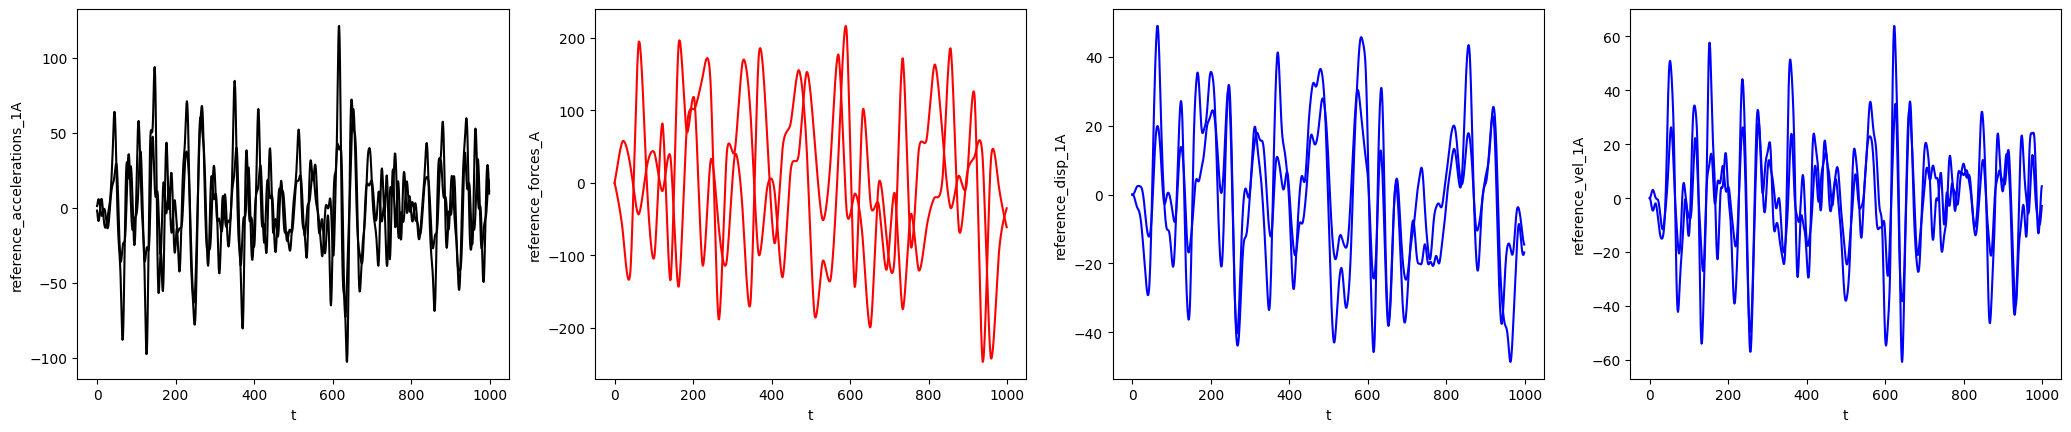

In [45]:
# Plots of the "actual" data (accelerations) and "hidden" (latent) data (forces) for experiments 1A-

fig = plt.figure(figsize=[4*6.4, 4.8])
ax1 = fig.add_subplot(141)
ax1.set_xlabel("t")
ax1.set_ylabel("reference_accelerations_1A")
ax1.plot(reference_accelerations_1A, c='k')
ax2 = fig.add_subplot(142)
ax2.set_xlabel("t")
ax2.set_ylabel("reference_forces_A")
ax2.plot(reference_forces_A, c='r')
ax3 = fig.add_subplot(143)
ax3.set_xlabel("t")
ax3.set_ylabel("reference_disp_1A")
ax3.plot(reference_disp_1A, c='b')
ax4 = fig.add_subplot(144)
ax4.set_xlabel("t")
ax4.set_ylabel("reference_vel_1A")
ax4.plot(reference_vel_1A, c='b')
plt.show()

#### **4.1.1. Experiment 1A1**


Inference ran in 320.29s.


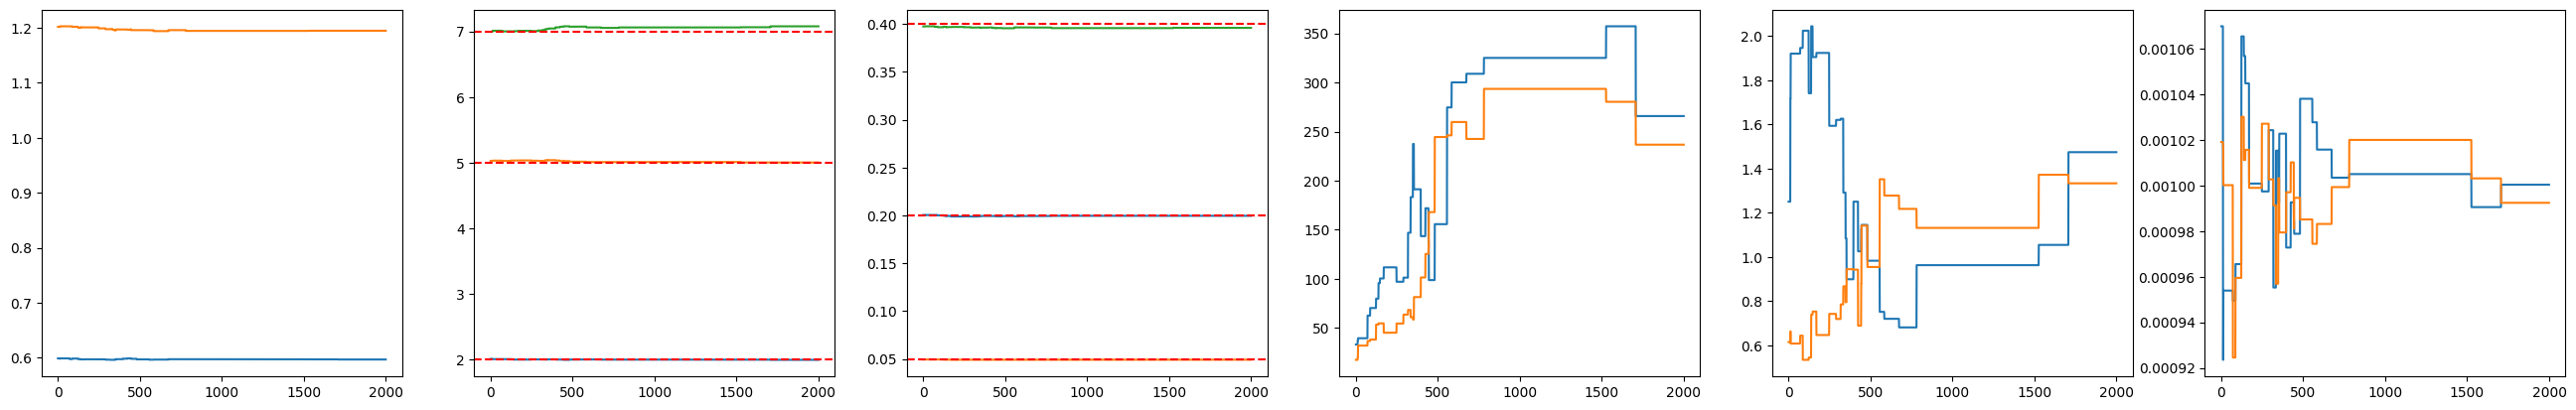

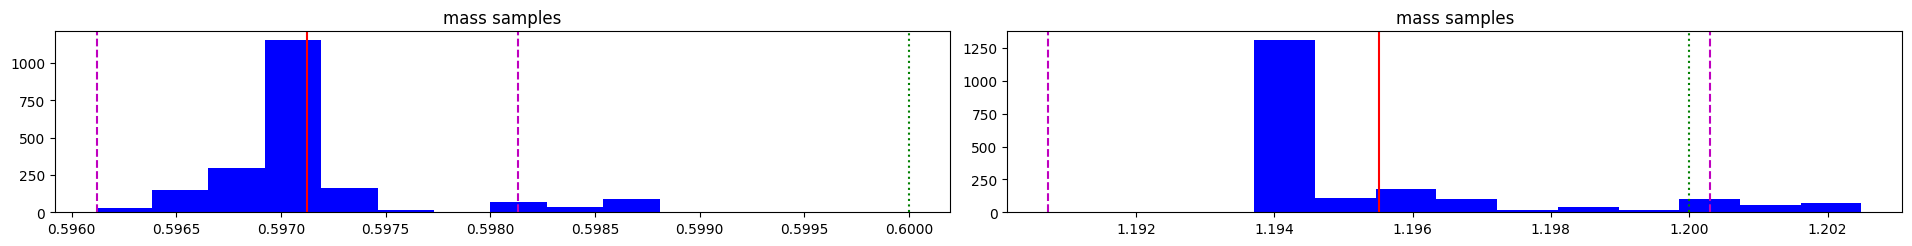

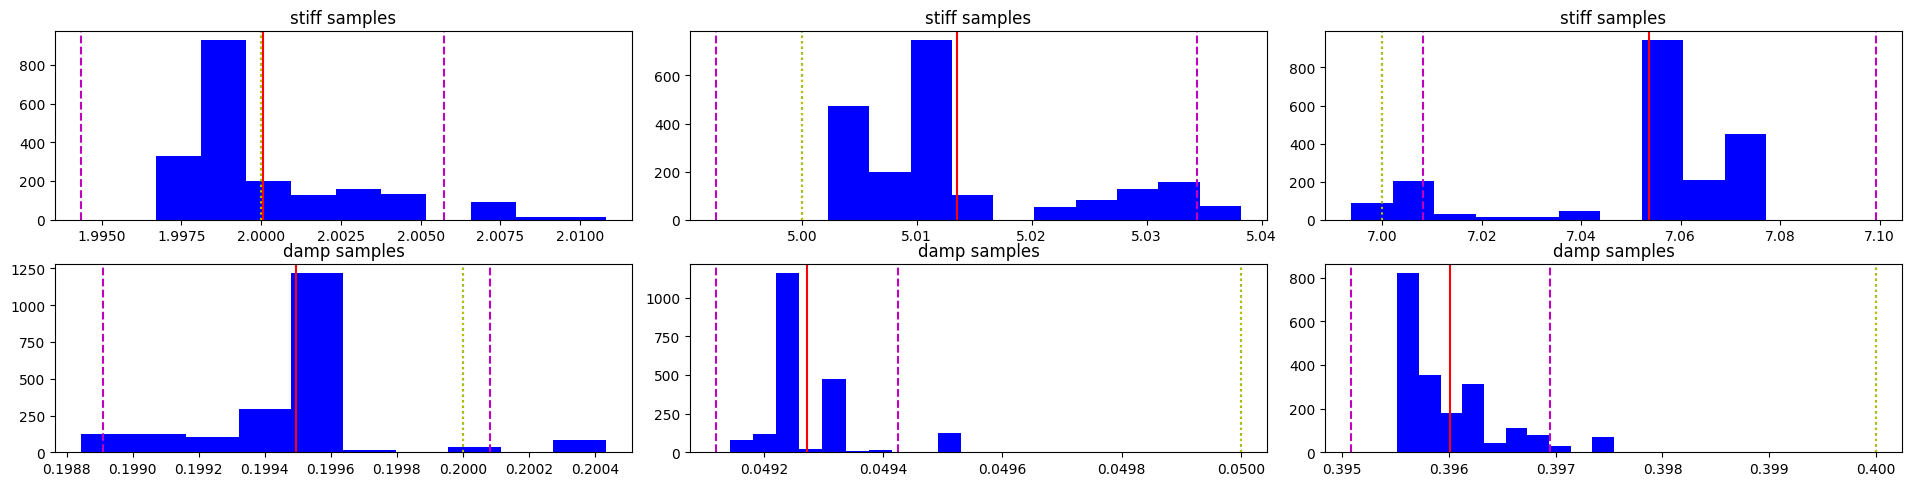

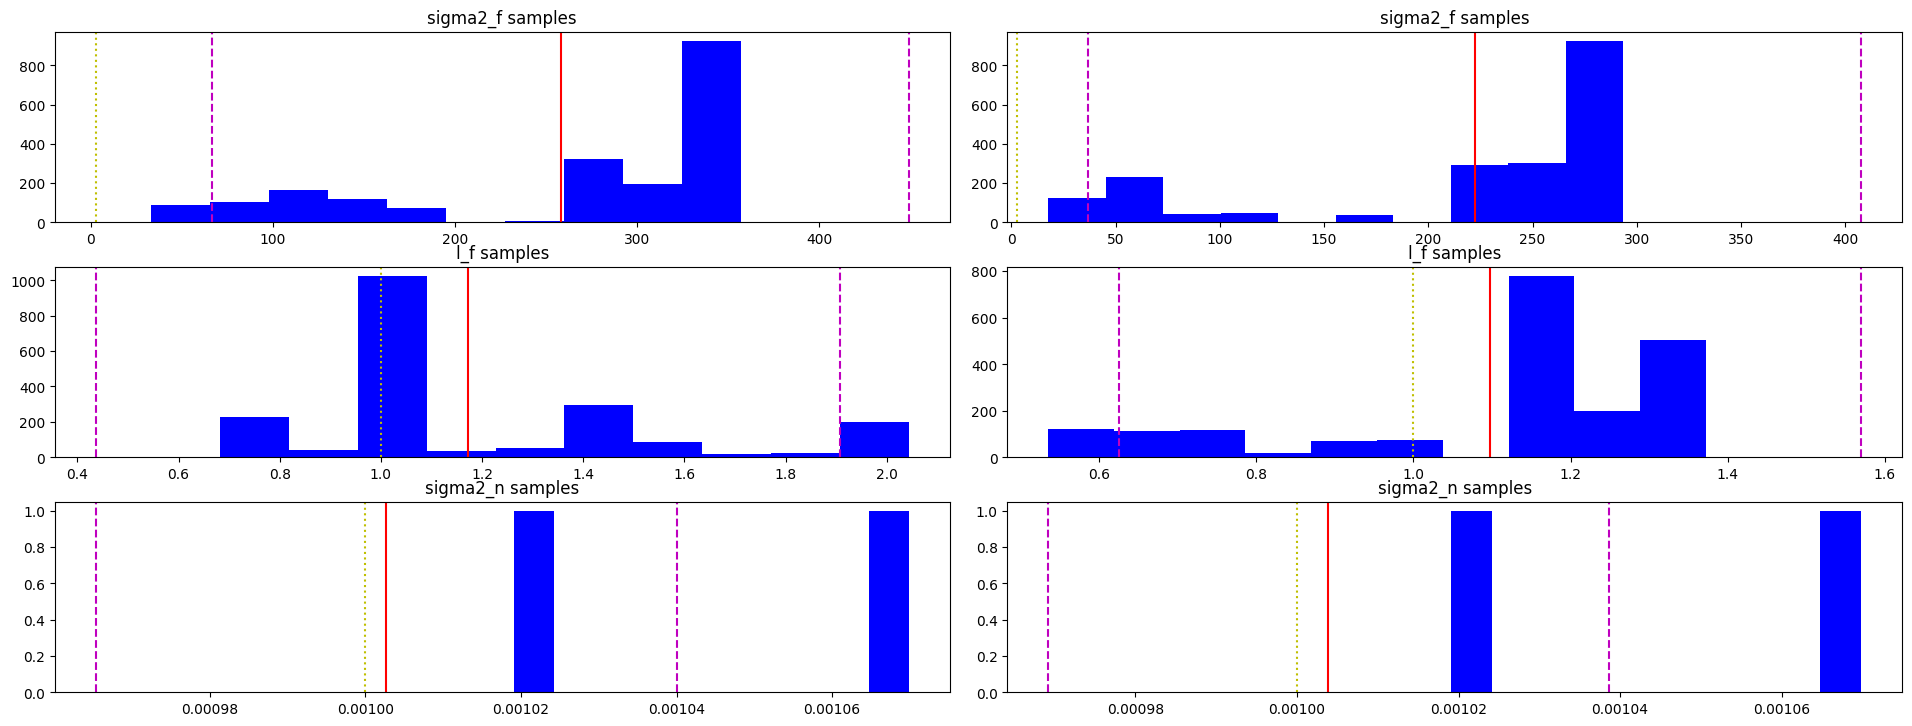

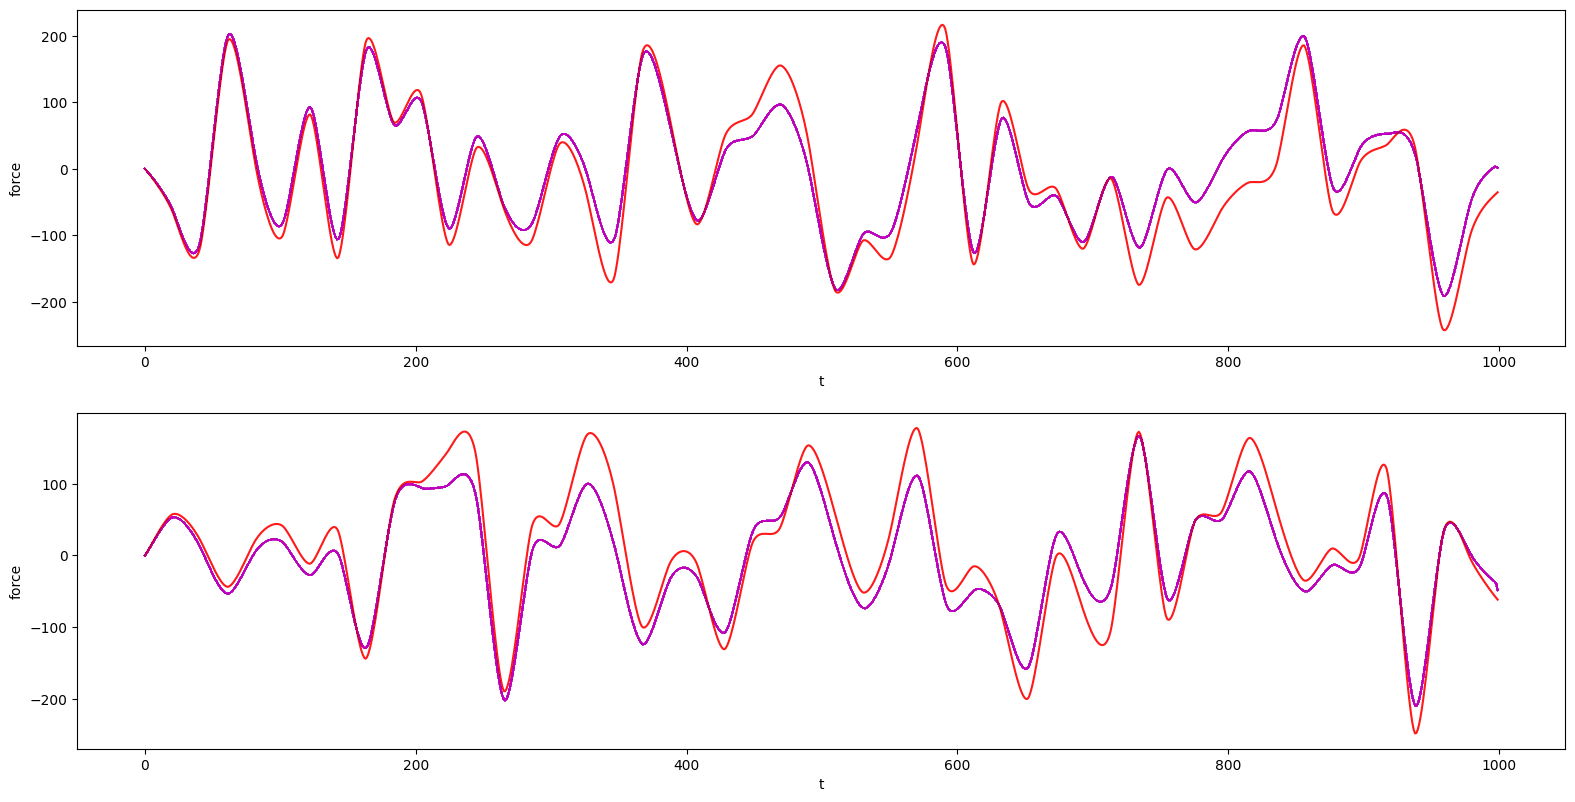

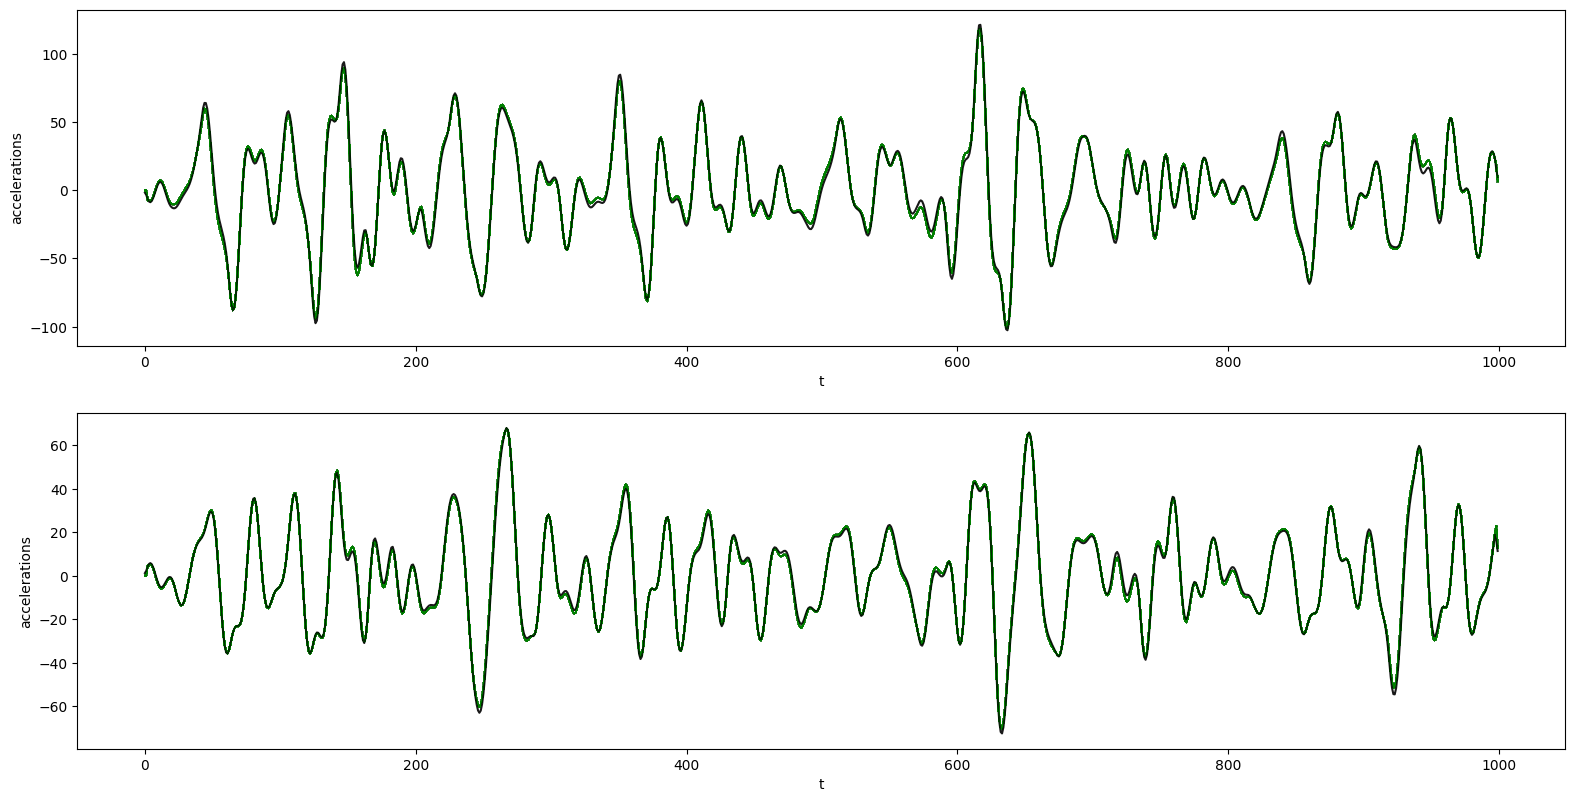

In [46]:
# Experiment 1A1 

(log_joint_prior,
log_mass_prior,
log_stiff_prior, 
log_damp_prior, 
log_sigma2_f_prior, 
log_l_f_prior, 
log_sigma2_n_prior) = build_log_priors(
    np.log(reference_mass_list_1), [0.001]*ndof_1,
    np.log([reference_stiff_list_1[_] for _ in range(ndof_1+1)]), [0.001]*(ndof_1+1),
    np.log([reference_damp_list_1[_] for _ in range(ndof_1+1)]), [0.001]*(ndof_1+1),
    np.log([2.5]*ndof_1), [0.5]*ndof_1,
    np.log([1.0]*ndof_1), [1.0]*ndof_1,
    np.log([1e-3]*ndof_1), [1e-3]*ndof_1,
)

log_marginal_posterior_samples_1A1 = run_gplfm_mcmc(
    log_joint_prior, log_mass_prior, log_stiff_prior, log_damp_prior, log_sigma2_f_prior, log_l_f_prior, log_sigma2_n_prior,
    reference_delta_t_A, reference_accelerations_1A,
    num_results=2000, num_burnin_steps=200, new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=[0.001, 0.001, 0.001, 0.2, 0.2, 0.2]))

show_results(
    log_marginal_posterior_samples_1A1, log_mass_prior, log_stiff_prior, log_damp_prior, log_sigma2_f_prior, log_l_f_prior, log_sigma2_n_prior,
    reference_delta_t_A, reference_accelerations_1A,
    reference_forces_A, reference_disp_1A, reference_vel_1A,
    reference_mass_list_1, reference_stiff_list_1, reference_damp_list_1,
    content=["chains", "marginal_posterior", "forces", "accelerations"], samples_subset_range=range(1800,2000))

#### **4.1.1. Experiment 1A2**

[1.7868517156418724, 4.451492029063609, 5.766838930250318]
[0.19235979940262457, 0.05919693435657001, 0.4730670990106992]
Inference ran in 390.06s.


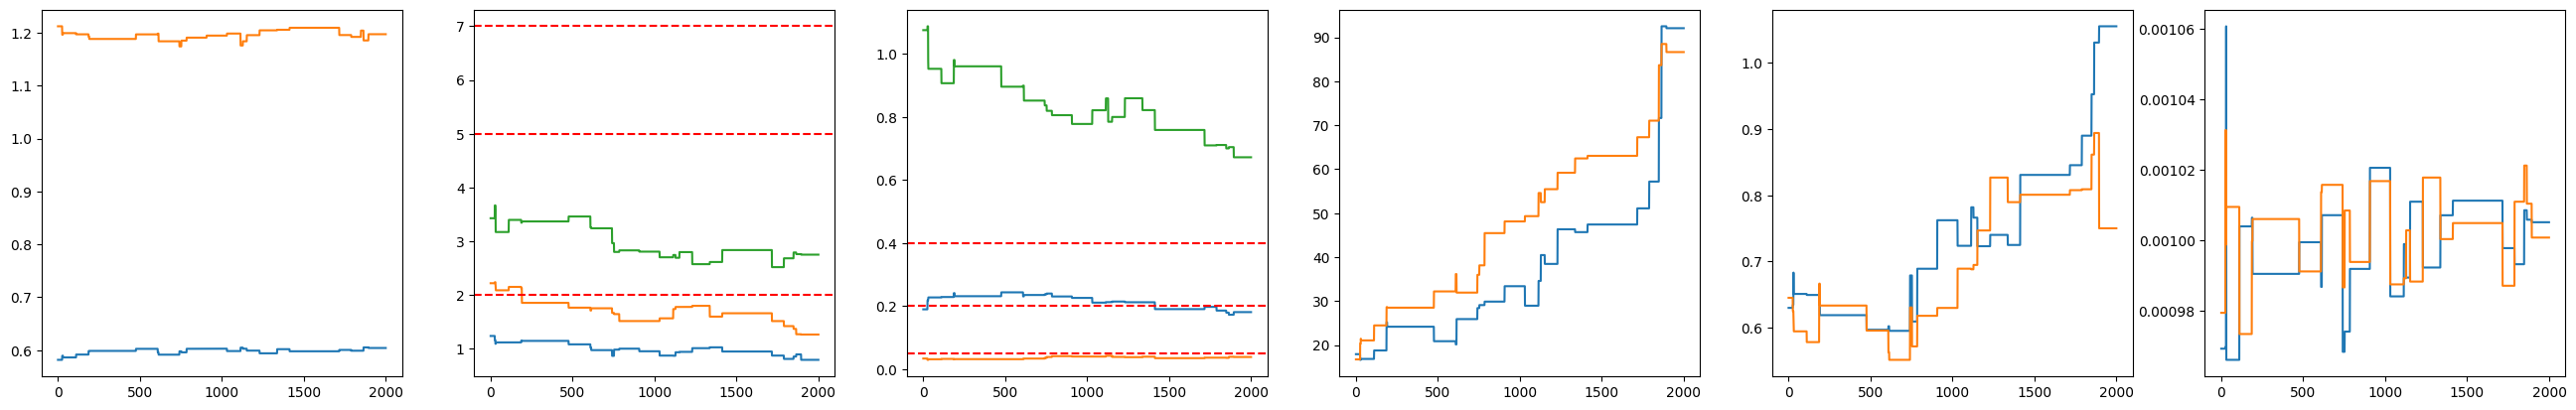

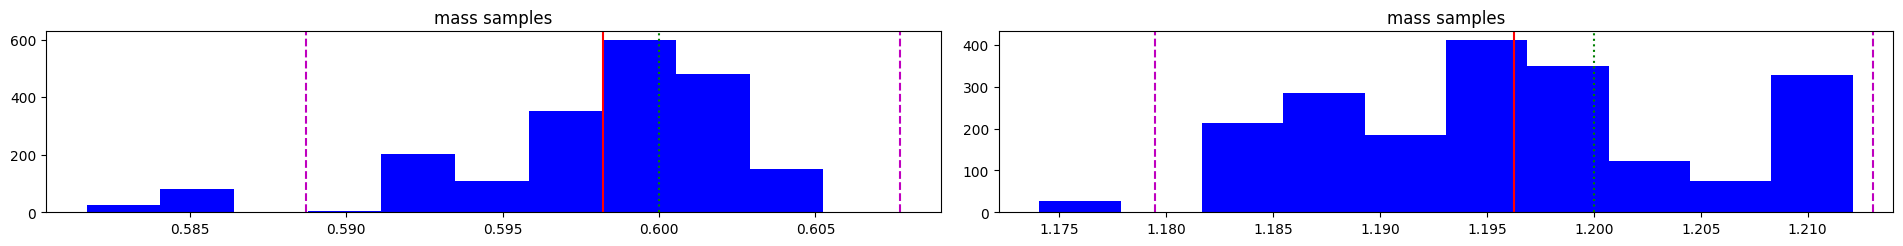

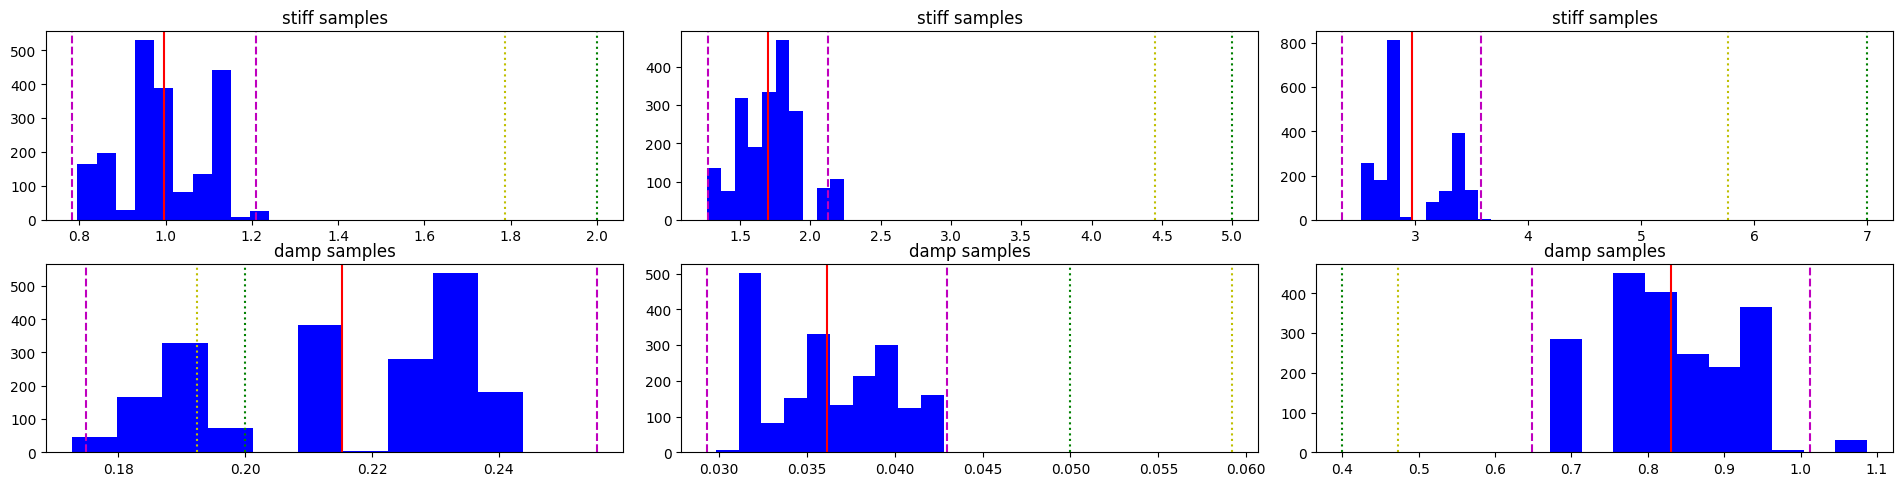

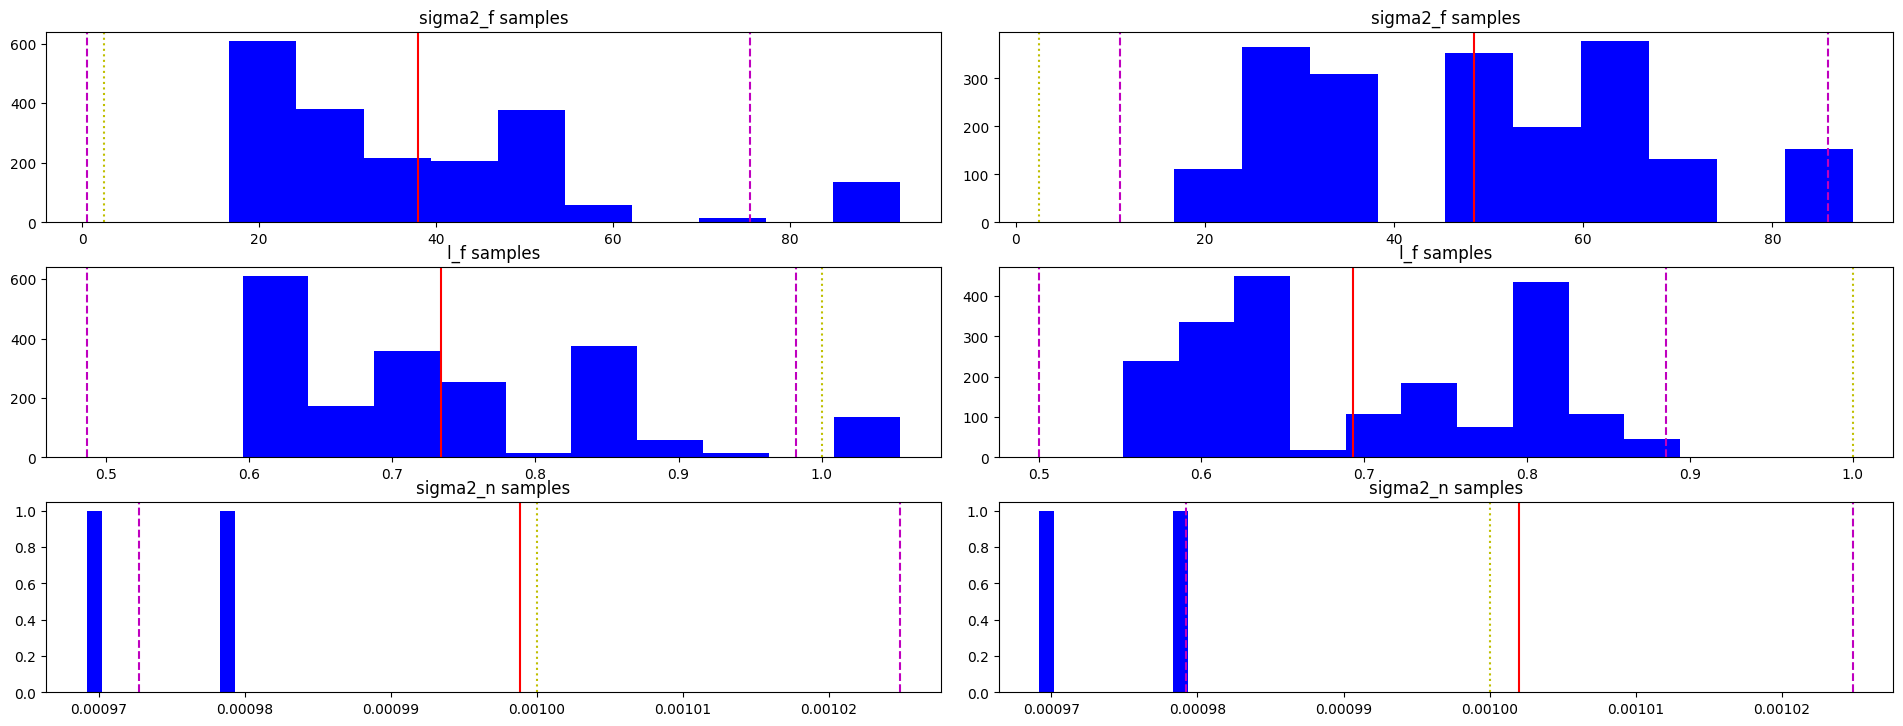

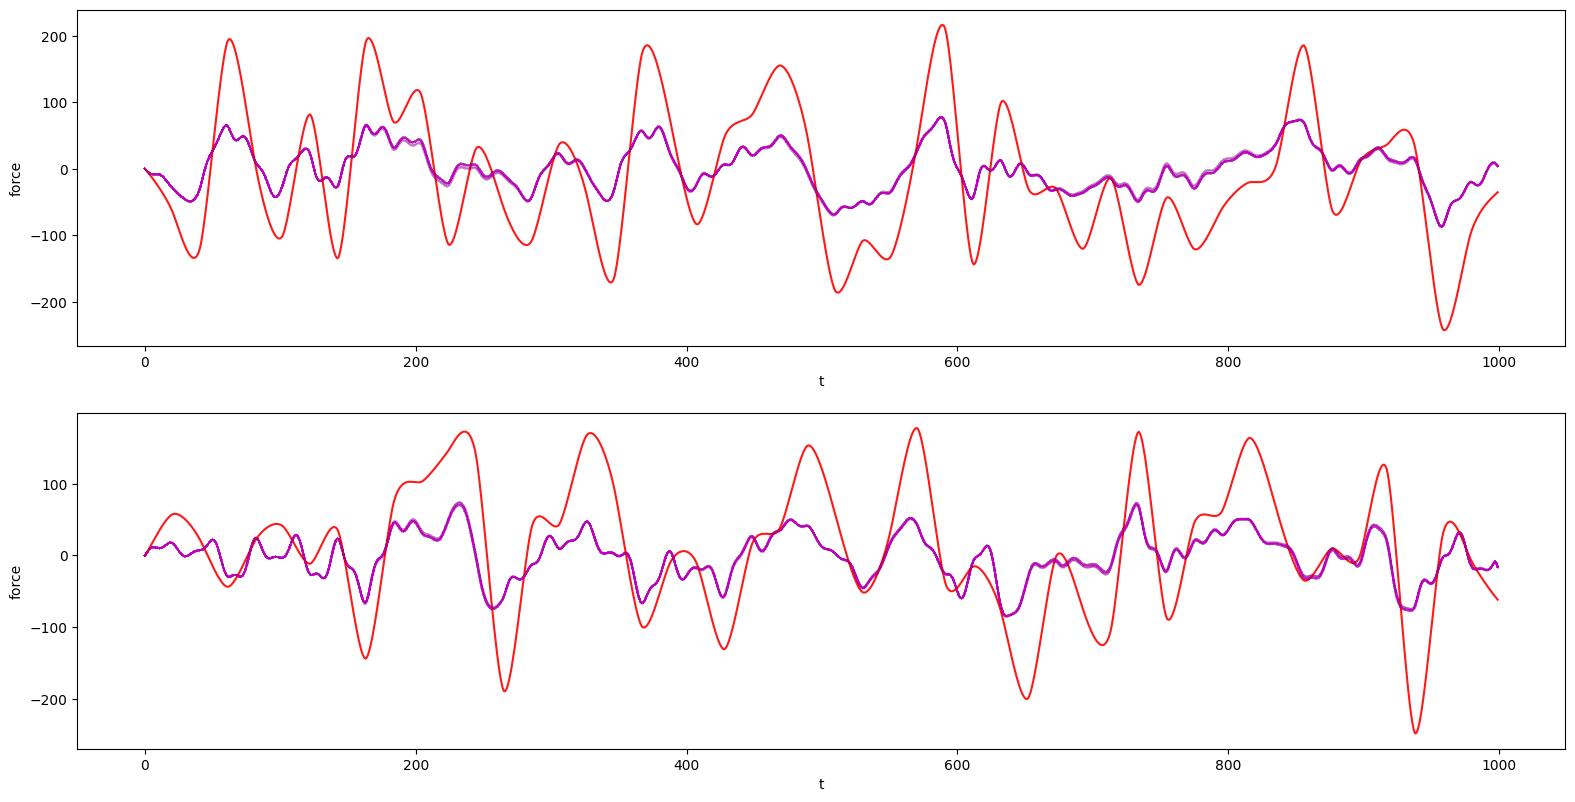

In [25]:
# Experiment 1A2 

stiff_random_mults_1A2=0.4*np.random.random(size=(ndof_1+1,))+0.8
damp_random_mults_1A2=0.4*np.random.random(size=(ndof_1+1,))+0.8

print([stiff_random_mults_1A2[_]*reference_stiff_list_1[_] for _ in range(ndof_1+1)])
print([damp_random_mults_1A2[_]*reference_damp_list_1[_] for _ in range(ndof_1+1)])

(log_joint_prior,
log_mass_prior,
log_stiff_prior, 
log_damp_prior, 
log_sigma2_f_prior, 
log_l_f_prior, 
log_sigma2_n_prior) = build_log_priors(
    np.log(reference_mass_list_1), [0.001]*ndof_1,
    np.log([stiff_random_mults_1A2[_]*reference_stiff_list_1[_] for _ in range(ndof_1+1)]), [0.2]*(ndof_1+1),
    np.log([damp_random_mults_1A2[_]*reference_damp_list_1[_] for _ in range(ndof_1+1)]), [0.2]*(ndof_1+1),
    np.log([2.5]*ndof_1), [0.5]*ndof_1,
    np.log([1.0]*ndof_1), [1.0]*ndof_1,
    np.log([1e-3]*ndof_1), [1e-3]*ndof_1,
)

log_marginal_posterior_samples_1A2 = run_gplfm_mcmc(
    log_joint_prior, log_mass_prior, log_stiff_prior, log_damp_prior, log_sigma2_f_prior, log_l_f_prior, log_sigma2_n_prior,
    reference_delta_t_A, reference_accelerations_1A,
    num_results=2000, num_burnin_steps=200, new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=[0.001, 0.02, 0.02, 0.2, 0.2, 0.2]))

show_results(
    log_marginal_posterior_samples_1A2, log_mass_prior, log_stiff_prior, log_damp_prior, log_sigma2_f_prior, log_l_f_prior, log_sigma2_n_prior,
    reference_delta_t_A, reference_accelerations_1A,
    reference_forces_A, reference_disp_1A, reference_vel_1A,
    reference_mass_list_1, reference_stiff_list_1, reference_damp_list_1,
    content=["chains", "marginal_posterior", "forces"], samples_subset_range=range(1800,2000))

#### **4.1.1. Experiment 1B1**

In [ ]:
# Experiment 1B1

(log_joint_prior,
log_mass_prior,
log_stiff_prior, 
log_damp_prior, 
log_sigma2_f_prior, 
log_l_f_prior, 
log_sigma2_n_prior) = build_log_priors(
    np.log(reference_mass_list_1), [0.001]*ndof_1,
    np.log([reference_stiff_list_1[_] for _ in range(ndof_1+1)]), [0.01]*(ndof_1+1),
    np.log([reference_damp_list_1[_] for _ in range(ndof_1+1)]), [0.01]*(ndof_1+1),
    np.log([2.5]*ndof_1), [0.5]*ndof_1,
    np.log([1.0]*ndof_1), [1.0]*ndof_1,
    np.log([1e-3]*ndof_1), [1e-3]*ndof_1,
)

log_marginal_posterior_samples_1B1 = run_gplfm_mcmc(
    log_joint_prior, log_mass_prior, log_stiff_prior, log_damp_prior, log_sigma2_f_prior, log_l_f_prior, log_sigma2_n_prior,
    reference_delta_t_B, reference_accelerations_1B,
    num_results=2000, num_burnin_steps=500, new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=[0.001, 0.05, 0.05, 0.1, 0.1, 0.1]))

show_results(
    log_marginal_posterior_samples_1B1, log_mass_prior, log_stiff_prior, log_damp_prior, log_sigma2_f_prior, log_l_f_prior, log_sigma2_n_prior,
    reference_delta_t_B, reference_accelerations_1B,
    reference_forces_B, reference_disp_1B, reference_vel_1B,
    reference_mass_list_1, reference_stiff_list_1, reference_damp_list_1,
    content=["chains", "marginal_posterior", "forces"], samples_subset_range=range(1800,2000))